
#### CSCI-E-109B Advanced Topics in Data Science | Prof. Protopapas, Glickman and Tanner

## FINAL PROJECT | **GROUP 48** | Milestone 3 - Final Submission
### Topic E - Predicting Project Success

# **"Visualizing Project Success using Iterative Bayesian Simulation"**

#### *May 10, 2020*



**Team Members:**
- Michael Lee, *mil726@g.harvard.edu*
- Micah Nickerson, *min021@g.harvard.edu*
- Daniel Olal, *dolal@crystal.harvard.edu*


**Project TF**
- Brandon Walker


**Project Topic**

Successful project planning is a critical part of the success of any business or organization in order to minimize unanticipated delays or cost overruns.  With our data science models, we strive to predict project success or failure based on historical project planning records, and give project managers more power to control their own success.

For this analysis, we define project success as a combination of two metrics: **budgetary success** and **schedule success**.  Budgetary success occurs when the project is completed **on budget**, and schedule success occurs when the project is completed **on schedule**. Note that on budget and on schedule indicates that the project is completed **within an interval of acceptable deviation**, with upper and lower bounds determined by project type.

**Description of Data Set**

Our dataset is a **collection of capital projects provided by the Mayor’s Office of Operations in New York City**.  The projects in the database include projects managed by NYC city agencies which have a budget of $25 million or more.   The information in the dataset includes the date of the project status update, the project ID (PID), the project name, the project description, and the category of the project.  Details about the borough, managing agency, client agency are also provided.  The progress of the project is defined based on variables including the current phase of the project, design start date, budget forecast, the latest budget changes, the total budget changes, forecast completion, latest schedule changes, and total schedule changes. The **dataset contains multiple rows per project** (per PID), providing time stamped sequential updates to each of the forecast completion, latest budget changes and latest schedule changes.

# -----------------------------------------------------------------------------------------------------------------

*- Load Dependencies*

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

# from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso


import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.utils import plot_model

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import itertools
import collections
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from datetime import datetime

from statistics import mean

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Google Colab specific code:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


- *Load and Clean the Dataset*

In [0]:
# read the file

filepath = "/content/drive/Shared drives/CSCI E-109B - Adv Data Sci - Final Project (E)/Data/"
nyc_cp_path = "Capital_Projects.csv"
nyc_cp = filepath+nyc_cp_path

con_flags = "Construction_Flags.csv"
nyc_cf = filepath + con_flags

nyc_cp_df = pd.read_csv(nyc_cp, encoding= 'unicode_escape')

nyc_cf = pd.read_csv(nyc_cf)

nyc_cp_df = nyc_cp_df.merge(nyc_cf, left_index=True, right_index=True)

nyc_cp_df.columns = ['Column_Description','Date_Reported_As_Of', 'PID', 
                     'Project_Name', 'Description', 'Category',
                     'Borough', 'Managing_Agency', 'Client_Agency', 'Current_Phase',
                     'Design_Start', 'Budget_Forecast', 'Latest_Budget_Changes',
                     'Total_Budget_Changes', 'Forecast_Completion',
                     'Latest_Schedule_Changes', 'Total_Schedule_Changes','Project Type',
                     'Site Storage']

nyc_cp_df.dropna(subset=['Design_Start'])

datetime_cols = ['Date_Reported_As_Of', 'Design_Start', 'Forecast_Completion']
for cols in datetime_cols:
    try:
      nyc_cp_df[cols] = pd.to_datetime(nyc_cp_df[cols])
    except:
      pass

numeric_cols = ['PID',	'Budget_Forecast',	'Latest_Budget_Changes',	
                'Total_Budget_Changes',	'Latest_Schedule_Changes',	'Total_Schedule_Changes']
for cols in numeric_cols:
    try:
      nyc_cp_df[cols] = pd.to_numeric(nyc_cp_df[cols],errors='coerce')
    except:
      pass

nyc_cp_df_labels = nyc_cp_df[0:2]
nyc_cp_df = nyc_cp_df.drop([0,1], axis =0)

#convert Design_Start to datetime
nyc_cp_df['Design_Start'] = pd.to_datetime(nyc_cp_df['Design_Start'])
nyc_cp_df['Date_Reported_As_Of'] = pd.to_datetime(nyc_cp_df['Date_Reported_As_Of'])
nyc_cp_df['Forecast_Completion'] = pd.to_datetime(nyc_cp_df['Forecast_Completion'])

nyc_cp_df_numeric = nyc_cp_df.select_dtypes(include = ['float64', 'int64'])
nyc_cp_df_numeric = nyc_cp_df_numeric.dropna()

display(nyc_cp_df.head(3))
print("\n\n")
display(nyc_cp_df_labels)
print("\n\n")
display(nyc_cp_df.dtypes)

,Column_Description,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Project Type,Site Storage
2,NaN,2014-05-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Design,2013-09-23,182980960.0,-1915400.0,-4318643.37,2020-01-14,1.0,270.0,Civil,1
3,NaN,2015-02-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,168751769.0,-14229191.0,-4318643.37,2020-07-19,187.0,270.0,Civil,1
4,NaN,2015-08-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,165532447.0,-3219322.0,-4318643.37,2020-08-08,20.0,270.0,Civil,1


,Column_Description,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Project Type,Site Storage
0,Column Description,Reporting period (mm/yyyy),NaN,Project Name,Description of the project details,The purpose of type of project,"Borough where the project is being built, if a...",Agency that is managing the project developmen...,The agency that is the business owner/sponsor ...,The project phase at the point in time of the ...,The date the project started,NaN,NaN,NaN,The date projected for project completion,NaN,NaN,"Category of the Project - Civil, Building, Par...",Is there site storage available for material?
1,"Additional Notes \n(where applicable, include ...",NaN,NaN,NaN,NaN,Projects may have more than one category.,NaN,NaN,NaN,Design - Following the scoping/planning for th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Categorical Variable - Type of project changes...,Categorical Variable - 0-No Storage/Deliver-an...


Column_Description                 object
Date_Reported_As_Of        datetime64[ns]
PID                               float64
Project_Name                       object
Description                        object
Category                           object
Borough                            object
Managing_Agency                    object
Client_Agency                      object
Current_Phase                      object
Design_Start               datetime64[ns]
Budget_Forecast                   float64
Latest_Budget_Changes             float64
Total_Budget_Changes              float64
Forecast_Completion        datetime64[ns]
Latest_Schedule_Changes           float64
Total_Schedule_Changes            float64
Project Type                       object
Site Storage                       object
dtype: object

- *Process the Dataset:*

In [0]:
unique_projects =  np.unique(nyc_cp_df[["PID"]].values)
unique_projects.sort() #sort in ascending order
 
print("Number of Projects in the Dataset: %s\n\n" % len(unique_projects))

unique_projects

Number of Projects in the Dataset: 378




array([   3.,    7.,   18.,   25.,   34.,   53.,   58.,   91.,   92.,
         94.,   96.,   97.,   98.,  101.,  106.,  108.,  111.,  112.,
        113.,  114.,  116.,  117.,  120.,  131.,  146.,  151.,  166.,
        170.,  172.,  180.,  184.,  186.,  191.,  193.,  204.,  206.,
        267.,  304.,  313.,  314.,  347.,  349.,  360.,  364.,  366.,
        370.,  371.,  372.,  373.,  374.,  385.,  388.,  394.,  398.,
        402.,  403.,  405.,  406.,  409.,  416.,  423.,  427.,  430.,
        431.,  432.,  443.,  444.,  448.,  449.,  450.,  452.,  453.,
        454.,  455.,  470.,  472.,  473.,  474.,  475.,  476.,  477.,
        478.,  480.,  481.,  482.,  484.,  498.,  499.,  502.,  503.,
        504.,  505.,  506.,  507.,  509.,  510.,  512.,  514.,  515.,
        516.,  519.,  520.,  522.,  533.,  534.,  535.,  536.,  537.,
        538.,  539.,  540.,  541.,  542.,  544.,  545.,  546.,  548.,
        550.,  553.,  554.,  555.,  556.,  557.,  558.,  560.,  561.,
        567.,  568.,

- Add initial binary and time-delta data
  - Add project phase timelines (*i.e. start of construction*)

In [0]:
#Add binary and time delta data regarding schedule and when construction began

##################

#empty columns
nyc_cp_df['Construction_Start'] = 0
nyc_cp_df['Under_Construction'] = 0
nyc_cp_df['Over_Budget'] = 0
nyc_cp_df['Over_Schedule'] = 0
nyc_cp_df['Over_Budget_And_Schedule'] = 0
nyc_cp_df['On_Budget_And_Schedule'] = 0
nyc_cp_df['Total_Design_Days'] = 0
nyc_cp_df['Total_Construction_Days'] = 0
nyc_cp_df['Total_Days'] = 0
nyc_cp_df['Elapsed_Days_of_Date_Reported_As_Of'] = 0

row_start = nyc_cp_df.index.min()
row_end = nyc_cp_df.shape[0]+1

##################

#run through dataset
for project in unique_projects:

##################

  # Add Start of Construction Times

  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  nyc_cp_df_slice = nyc_cp_df_slice[nyc_cp_df_slice['Current_Phase'] == 'Construction']
  if nyc_cp_df_slice.empty: #if not in construction yet
    pass
  else: #record when first construction report was i.e. start of construction
    start_of_construction = nyc_cp_df_slice['Date_Reported_As_Of'].min() #earliest construction date
    for row in range(row_start, row_end):
      if nyc_cp_df.loc[row, 'PID'] == project:
        nyc_cp_df.loc[row, 'Construction_Start'] = start_of_construction
        nyc_cp_df.loc[row, 'Under_Construction'] = 1 #binary flag

##################

  # Add Overbudget descriptors

  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  nyc_cp_df_slice = nyc_cp_df_slice[nyc_cp_df_slice['Total_Budget_Changes'] > 0]
  if nyc_cp_df_slice.empty: #if not overbudget
    pass
  else:
    for row in range(row_start, row_end):
      if nyc_cp_df.loc[row, 'PID'] == project:
        nyc_cp_df.loc[row, 'Over_Budget'] = 1 #binary flag

##################

  # Add Overschedule descriptors

  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  nyc_cp_df_slice = nyc_cp_df_slice[nyc_cp_df_slice['Total_Schedule_Changes'] > 0]
  if nyc_cp_df_slice.empty: #if not overschedule
    pass
  else: 
    for row in range(row_start, row_end):
      if nyc_cp_df.loc[row, 'PID'] == project:
        nyc_cp_df.loc[row, 'Over_Schedule'] = 1 #binary flag
        if (nyc_cp_df.loc[row, 'Over_Schedule'] == 1) & (nyc_cp_df.loc[row, 'Over_Budget'] == 1):
           nyc_cp_df.loc[row, 'Over_Budget_And_Schedule'] = 1 #binary flag
        if (nyc_cp_df.loc[row, 'Over_Schedule'] == 0) & (nyc_cp_df.loc[row, 'Over_Budget'] == 0):
           nyc_cp_df.loc[row, 'On_Budget_And_Schedule'] = 1 #binary flag

##################

  # Add Elapsed project times

  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  latest_date = nyc_cp_df_slice['Date_Reported_As_Of'].max()
  design_start = nyc_cp_df_slice['Design_Start'].max()
  max_project_days = (latest_date - design_start).days

  for row in range(row_start, row_end):
    if nyc_cp_df.loc[row, 'PID'] == project:
      elapsed_days_of_date_reported_as_of = (nyc_cp_df.loc[row, 'Date_Reported_As_Of'] - nyc_cp_df.loc[row, 'Design_Start']).days #calculate the number of elapsed days for that row  
      nyc_cp_df.loc[row, 'Elapsed_Days_of_Date_Reported_As_Of'] = elapsed_days_of_date_reported_as_of
      nyc_cp_df.loc[row, 'Total_Days'] = (nyc_cp_df.loc[row, 'Forecast_Completion'] - nyc_cp_df.loc[row, 'Design_Start']).days
      if nyc_cp_df.loc[row, 'Under_Construction'] == 0: #if not under construction
        nyc_cp_df.loc[row, 'Total_Construction_Days'] = 0
        nyc_cp_df.loc[row, 'Total_Design_Days'] = max_project_days
      else:
        nyc_cp_df.loc[row, 'Total_Construction_Days'] = (nyc_cp_df.loc[row, 'Forecast_Completion'] - start_of_construction).days
        nyc_cp_df.loc[row, 'Total_Design_Days'] = (start_of_construction - nyc_cp_df.loc[row, 'Design_Start']).days

##################


In [0]:
# GROUP SET BY DESIGN INFORMATION - ONE ROW PER PROJECT ID
nyc_cp_df_PID_subset = nyc_cp_df.groupby(
   ['PID']
).aggregate(
    {  'Date_Reported_As_Of': 'first',
       'Current_Phase': 'first',
       'Project_Name': 'first',
       'Description': 'first',
       'Category': 'first',
       'Borough': 'first',
       'Managing_Agency': 'first',
       'Client_Agency': 'first',
       'Current_Phase': 'first',
       'Design_Start': 'first',
       'Budget_Forecast': 'first',
       'Latest_Budget_Changes': 'last',
       'Total_Budget_Changes': 'last',
       'Forecast_Completion': 'first',
       'Latest_Schedule_Changes': 'last',
       'Total_Schedule_Changes': 'last',
       'Construction_Start': 'first',
       'Under_Construction': 'first',
       'Over_Budget': 'first',
       'Over_Schedule': 'first',
       'Over_Budget_And_Schedule': 'first',
       'On_Budget_And_Schedule': 'first',
       'Total_Design_Days': 'first',
       'Total_Construction_Days': 'first',
       'Total_Days' : 'first',  
       'Elapsed_Days_of_Date_Reported_As_Of' : 'first',
       'Project Type': 'first',
       'Site Storage': 'first',
    }
)

nyc_cp_df_PID_subset["Borough"][520.0] = "Manhattan" # correct for typo in dataset

nyc_cp_df_PID_subset.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date_Reported_As_Of,Current_Phase,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Construction_Start,Under_Construction,Over_Budget,Over_Schedule,Over_Budget_And_Schedule,On_Budget_And_Schedule,Total_Design_Days,Total_Construction_Days,Total_Days,Elapsed_Days_of_Date_Reported_As_Of,Project Type,Site Storage
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.0,2014-05-01,Design,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2013-09-23,182980960.0,-4664980.0,-4318643.37,2020-01-14,0.0,270.0,2016-01-01 00:00:00,1,0,1,0,0,830.0,1474.0,2304.0,220.0,Civil,1
7.0,2013-09-01,Design,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2013-05-01,53493000.0,1065884.0,15305457.00,2018-03-31,88.0,685.0,2016-01-01 00:00:00,1,1,1,1,0,975.0,820.0,1795.0,123.0,Building,0
18.0,2013-09-01,Construction,Croton Falls Pumping Station Construction,This project will construct a new pumping stat...,Water Supply,Carmel,DEP,DEP,2003-08-22,66616435.0,-1399611.0,1255175.02,2017-05-31,91.0,1014.0,2013-09-01 00:00:00,1,1,1,1,0,3663.0,1368.0,5031.0,3663.0,Civil,2


# -----------------------------------------------------------------------------------------------------------------

#EDA - Exploratory Data Analysis
- For EDA, Please See Milestone 3 EDA Notebook

# -----------------------------------------------------------------------------------------------------------------

# 1 - Data Augmentation

### Add Binary Categorical Variables Representing Scope:

In [0]:
# CONVERT THE PROJECT DESCRIPTIONS INTO BINARY CATEGORICAL VARIABLES REPRESENTING SCOPE

df = nyc_cp_df_PID_subset['Project_Name']
df = df.str.lower()
df = df.str.split()
df

PID
3.0       [26th, ward, waste, water, treatment, plant, p...
7.0       [bowery, bay, waste, water, treatment, plant, ...
18.0        [croton, falls, pumping, station, construction]
25.0                         [gowanus, facilities, upgrade]
34.0      [jamaica, waste, water, treatment, plant, upgr...
                                ...                        
1010.0              [prior, notice, sidewalks, -, brooklyn]
1011.0      [reconstruction, of, rosedale, area,, phase, 2]
1012.0      [reconstruction, of, front, street,, manhattan]
1013.0                        [grand, concourse,, phase, 5]
1014.0             [reconstruction, of, broadway, phase, 2]
Name: Project_Name, Length: 378, dtype: object

In [0]:
## CODE FOR TESTING IF WORD IS IN COLUMN
df_new = df[2:]
for i in range(df_new.shape[0]):
  for j in range (len(df_new.iloc[i])):
    if df_new.iloc[i][j]== 'fire':
      print (df_new.index[i])

510.0
553.0
589.0
837.0
838.0
850.0
856.0
980.0


In [0]:
# encode the scope indicator variables

df_new = df[2:]

df_augmented = nyc_cp_df_PID_subset.copy()
df_augmented['Scope'] = '0'
df_augmented['Divison'] = '0'
df_augmented['Material'] = '0'

scope_renovate = []
scope_rehabilitate = []
scope_restoration = []
scope_repair = []
scope_reconstruction = []
scope_upgrade = []
scope_building = []

for i in range(df_new.shape[0]):
  for j in range (len(df_new.iloc[i])):
    if df_new.iloc[i][j]== 'renovation':
      scope_renovate.append(df_new.index[i])

      # Rehabilitation
    elif df_new.iloc[i][j]== 'rehabilitation':
      scope_rehabilitate.append(df_new.index[i])
      # Restoration
    elif df_new.iloc[i][j]== 'restoration':
      scope_restoration.append(df_new.index[i])
      # Repair
    elif df_new.iloc[i][j]== 'repair':
      scope_repair.append(df_new.index[i])
      # Reconstruction
    elif df_new.iloc[i][j]== 'reconstruction':
      scope_reconstruction.append(df_new.index[i])
      # upgrade
    elif df_new.iloc[i][j]== 'upgrade':
      scope_upgrade.append(df_new.index[i])
      # building
    elif df_new.iloc[i][j]== 'building':
      scope_building.append(df_new.index[i])

df_augmented.Scope.loc[scope_renovate] = 1. #renovate
df_augmented.Scope.loc[scope_rehabilitate] = 2. #rehabilate
df_augmented.Scope.loc[scope_restoration] = 3. #restoration
df_augmented.Scope.loc[scope_repair] = 4. #repair
df_augmented.Scope.loc[scope_reconstruction] = 5. #reconstruction
df_augmented.Scope.loc[scope_upgrade] = 6. #upgrade
df_augmented.Scope.loc[scope_building] = 7. #building

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


We then encode predictor variables indicating the 50 divisions of construction information, as based on Construction Specification Institute (CSI)'s Master Format: https://en.wikipedia.org/wiki/50_Divisions

In [0]:
#encode the CSI divisions

division_electrical = []
division_landscaping = []
division_painting = []
division_electronic = []
division_communications = []
division_security = []
division_safety = []
division_water = []
division_fire = []
division_power = []
division_waste = []
division_transport = []

for i in range(df_new.shape[0]):
  for j in range (len(df_new.iloc[i])):
    if df_new.iloc[i][j]== 'electrical':
      division_electrical.append(df_new.index[i])
    elif df_new.iloc[i][j]== 'landscaping':
      division_landscaping.append(df_new.index[i])
    elif df_new.iloc[i][j]== 'painting':
      division_painting.append(df_new.index[i])
    elif df_new.iloc[i][j]== 'electronic':
      division_electronic.append(df_new.index[i])
    elif df_new.iloc[i][j]== 'communications':
      division_communications.append(df_new.index[i])
    elif df_new.iloc[i][j]== 'security':
      division_security.append(df_new.index[i])
    elif df_new.iloc[i][j]== 'safety':
      division_safety.append(df_new.index[i]) # safety is highly represented
    elif df_new.iloc[i][j]== 'water':
      division_water.append(df_new.index[i]) # water is highly represented
    elif df_new.iloc[i][j]== 'fire':
      division_fire.append(df_new.index[i]) 

      #POWER
    elif df_new.iloc[i][j]== 'power':
      division_power.append(df_new.index[i]) 

      #Waste
    elif df_new.iloc[i][j]== 'waste':
      division_waste.append(df_new.index[i]) # highly represented 

      #Transport
    elif df_new.iloc[i][j]== 'transport':
      division_transport.append(df_new.index[i])

df_augmented.Divison.loc[division_communications] = 1
df_augmented.Divison.loc[division_electrical] = 2
df_augmented.Divison.loc[division_electronic] = 3
df_augmented.Divison.loc[division_fire] = 4
df_augmented.Divison.loc[division_landscaping] = 5
df_augmented.Divison.loc[division_painting] = 6
df_augmented.Divison.loc[division_power] = 7
df_augmented.Divison.loc[division_safety] = 8
df_augmented.Divison.loc[division_security] = 9
df_augmented.Divison.loc[division_transport] = 10
df_augmented.Divison.loc[division_waste] = 11
df_augmented.Divison.loc[division_water] = 12

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
drop_cols = ['Project_Name','Description','Construction_Start','Under_Construction',
             'Over_Budget','Over_Schedule','Over_Budget_And_Schedule',
             'On_Budget_And_Schedule','Total_Design_Days','Total_Construction_Days',
             'Elapsed_Days_of_Date_Reported_As_Of']

df_augmented=df_augmented.drop(drop_cols,axis=1)
df_augmented = df_augmented.dropna()
df_augmented.head(4)

,Date_Reported_As_Of,Current_Phase,Category,Borough,Managing_Agency,Client_Agency,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Total_Days,Project Type,Site Storage,Scope,Divison,Material
PID,,,,,,,,,,,,,,,,,,,
3.0,2014-05-01,Design,Wastewater Treatment,Brooklyn,DEP,DEP,2013-09-23,182980960.0,-4664980.0,-4318643.37,2020-01-14,0.0,270.0,2304.0,Civil,1,0,12,0
7.0,2013-09-01,Design,Wastewater Treatment,Queens,DEP,DEP,2013-05-01,53493000.0,1065884.0,15305457.00,2018-03-31,88.0,685.0,1795.0,Building,0,0,12,0
18.0,2013-09-01,Construction,Water Supply,Carmel,DEP,DEP,2003-08-22,66616435.0,-1399611.0,1255175.02,2017-05-31,91.0,1014.0,5031.0,Civil,2,0,0,0
25.0,2013-09-01,Construction,Wastewater Treatment,Brooklyn,DEP,DEP,2001-11-01,198134067.0,33910.0,25233101.11,2014-08-05,0.0,1974.0,4660.0,Civil,1,6,0,0


In [0]:
#perform one-hot encoding for the categorical variables in dataset
def one_hot_encoding(train_df):
    train=train_df.copy()

    cat_var=[]
    for column_name in train.columns:
        if train[column_name].dtype == object:
            cat_var.append(column_name)
        else:
            pass
    print ('categorical variables are:',cat_var)
    train_dum=train[cat_var]
    train_dumm=pd.get_dummies(train_dum,columns=cat_var,drop_first=True) 
    train=train.drop(cat_var,axis=1)
    train_dummi=pd.concat([train,train_dumm], axis=1)
          
    return train_dummi

In [0]:
df_augmented = one_hot_encoding(df_augmented)

categorical variables are: ['Current_Phase', 'Category', 'Borough', 'Managing_Agency', 'Client_Agency', 'Project Type', 'Site Storage', 'Scope', 'Divison', 'Material']


In [0]:
#calculation of absolute error for use in BiGRU models
df_augmented["Budget_Actual"] = df_augmented["Budget_Forecast"]+df_augmented["Total_Budget_Changes"]
df_augmented["Budget_Absoulte_Error"] = abs(df_augmented["Budget_Forecast"]-df_augmented["Budget_Actual"])/df_augmented["Budget_Actual"]

df_augmented["Schedule_Actual"] = df_augmented["Total_Days"]+df_augmented["Total_Schedule_Changes"]
df_augmented["Schedule_Absoulte_Error"] = abs(df_augmented["Total_Days"]-df_augmented["Schedule_Actual"])/df_augmented["Schedule_Actual"]

df_augmented

,Date_Reported_As_Of,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Total_Days,Current_Phase_Construction Procurement,Current_Phase_Design,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,Borough_Brooklyn,Borough_Carmel,Borough_Citywide,Borough_Manhattan,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla,Managing_Agency_DDC,Managing_Agency_DEP,...,Managing_Agency_SCA,Client_Agency_BWT,Client_Agency_DCAS,Client_Agency_DCLA,Client_Agency_DEP,"Client_Agency_DEP, DOT","Client_Agency_DEP, DOT, EDC","Client_Agency_DEP, EDC",Client_Agency_DOC,Client_Agency_DOE,Client_Agency_DOT,"Client_Agency_DOT, Mayor's Office",Client_Agency_DPR,Client_Agency_DSBS,Client_Agency_DSNY,Client_Agency_EDC,Client_Agency_FDNY,Client_Agency_H+H,Client_Agency_Mayor's Office,Client_Agency_NYPD,Client_Agency_ORR,Project Type_Civil,Project Type_Park,Project Type_Street,Site Storage_1,Site Storage_2,Scope_4.0,Scope_5.0,Scope_6.0,Scope_7.0,Scope_0,Divison_4,Divison_7,Divison_8,Divison_12,Divison_0,Budget_Actual,Budget_Absoulte_Error,Schedule_Actual,Schedule_Absoulte_Error
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.0,2014-05-01,2013-09-23,182980960.0,-4664980.0,-4318643.37,2020-01-14,0.0,270.0,2304.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.786623e+08,0.024172,2574.0,0.104895
7.0,2013-09-01,2013-05-01,53493000.0,1065884.0,15305457.00,2018-03-31,88.0,685.0,1795.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6.879846e+07,0.222468,2480.0,0.276210
18.0,2013-09-01,2003-08-22,66616435.0,-1399611.0,1255175.02,2017-05-31,91.0,1014.0,5031.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,6.787161e+07,0.018493,6045.0,0.167742
25.0,2013-09-01,2001-11-01,198134067.0,33910.0,25233101.11,2014-08-05,0.0,1974.0,4660.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,2.233672e+08,0.112967,6634.0,0.297558
34.0,2013-09-01,1996-05-01,463790739.0,23238.0,-14632471.11,2014-07-01,184.0,2009.0,6635.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,4.491583e+08,0.032578,8644.0,0.232416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812.0,2018-03-01,2017-07-14,90381391.0,479666.0,-24805809.00,2021-09-03,0.0,0.0,1512.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,6.557558e+07,0.378278,1512.0,0.000000
813.0,2018-03-01,2017-02-02,102714402.0,730509.0,-5630761.00,2020-09-03,0.0,0.0,1309.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,9.708364e+07,0.057999,1309.0,0.000000
815.0,2018-03-01,2016-11-15,91594829.0,1475289.0,-10852601.00,2021-09-03,0.0,0.0,1753.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

In [0]:
#generate train and test datasets
train, test = train_test_split(df_augmented, test_size=0.2, random_state=109)

selected_model_1 = train.loc[430.0,:]
selected_model_2 = train.loc[431.0,:]
test = test.append(selected_model_1)
test = test.append(selected_model_2)

train = train.drop(labels=[430.0, 431.0])

### Project Word Cloud

The Project World Cloud identifies key words in the project descriptions which could be used to predict project success.

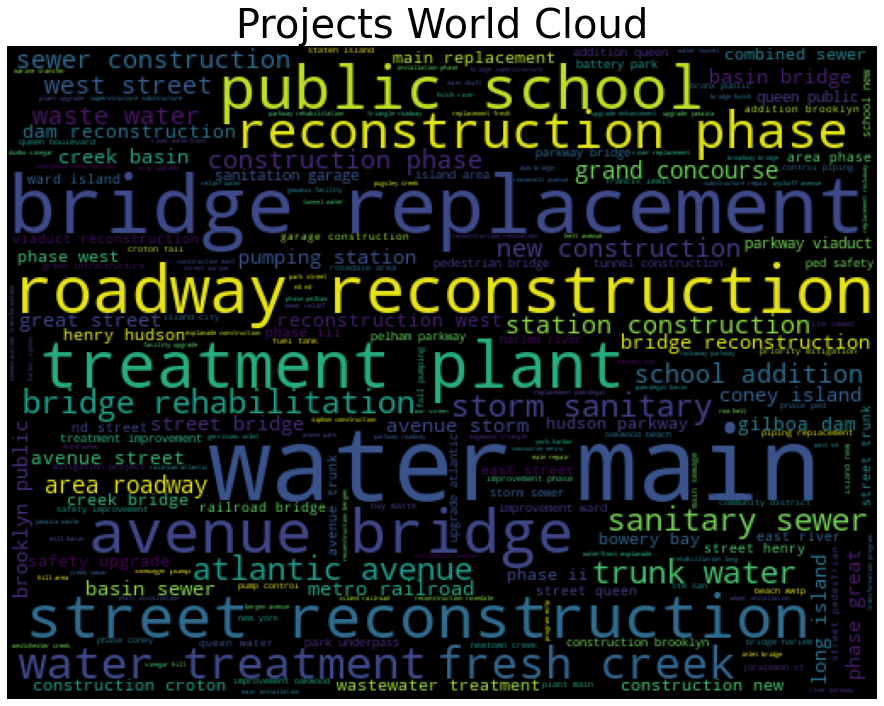

In [0]:
df = nyc_cp_df['Project_Name']
#REMOVE ALPHANUMERICS
df = df.replace('[^a-zA-Z0-9 ]', '', regex=True)
df = df.replace("th", '', regex=True)
df = df.replace('\'', '', regex=True)

#REMOVE NUMERICS
df = df.replace('\d+', '', regex=True)
df = df.str.lower()


#REMOVE STOPWORDS
stop = stopwords.words('english')
df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df = df.str.split()


# Lemmatize
lm = nltk.wordnet.WordNetLemmatizer()
df = df.apply(lambda x: " ".join([lm.lemmatize(word) for word in x]))
 
#MAKE WORD CLOUD
plt.subplots(figsize = (16,12))

wordcloud = WordCloud (background_color = 'black', width = 512, height = 384).generate(' '.join(str(word) for word in df))
plt.imshow(wordcloud) 
plt.axis('off') 
plt.title('Projects World Cloud', size=40)
plt.show()

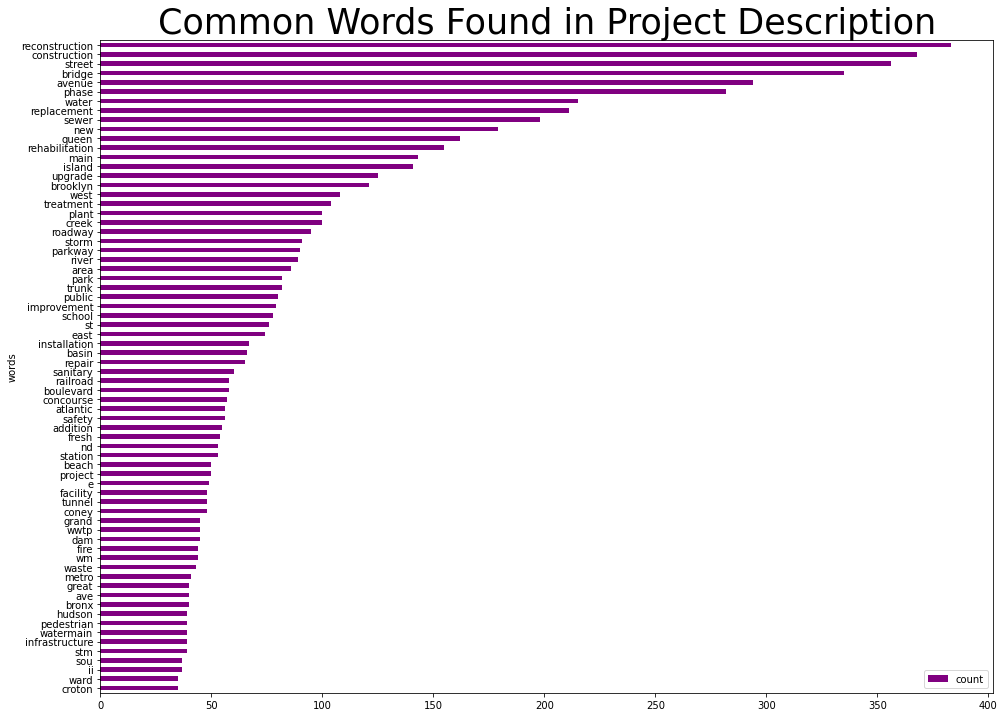

2       ward waste water treatment plant preliminary t...
3       ward waste water treatment plant preliminary t...
4       ward waste water treatment plant preliminary t...
5       ward waste water treatment plant preliminary t...
6       ward waste water treatment plant preliminary t...
                              ...                        
2256                       prior notice sidewalk brooklyn
2257                   reconstruction rosedale area phase
2258                reconstruction front street manhattan
2259                                grand concourse phase
2260                        reconstruction broadway phase
Name: Project_Name, Length: 2259, dtype: object

In [0]:
df2 = [l for l in df]
tokens = word_tokenize(re.sub("[^a-zA-Z]", " ", str(df2)))

token_counts = collections.Counter(tokens)
#token_counts.most_common(50)
common_words = pd.DataFrame(token_counts.most_common(70), columns=['words', 'count'])
common_words.head(20)

# Plot bar graph
fig, ax = plt.subplots(figsize=(16, 12))
common_words.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Project Description", size=35)

plt.show()

df

# -----------------------------------------------------------------------------------------------------------------

#2 - BiGRU Models

We built two Bidirectional Gated Recurrent Neural Network models to predict binary project and budget forecasts (ex. on schedule or over schedule) based on the project descriptions.

- Function to Calculate Absolute Percentage Error:

In [0]:
def calc_ape(original_value, current_value):
  """
  returns percentage of total changes divided by the most recent forecast
  """
  return abs((current_value - original_value) / original_value)

In [0]:
#### BIGRU DATASET ####

df_bigru = nyc_cp_df.copy()

df_bigru['Overbudget'] = df_bigru['Total_Budget_Changes']
df_bigru['Overschedule'] = df_bigru['Total_Schedule_Changes']

df_bigru['APE_sched'] = df_bigru['Total_Schedule_Changes']
df_bigru['APE_budget'] = df_bigru['Total_Schedule_Changes']

########################

# overbudget projects 
df_bigru.Overbudget[df_bigru.Overbudget.values > 0] = 1
df_bigru.Overbudget[df_bigru.Overbudget.values <= 0] = 0

########################

# overschedule projects
df_bigru.Overschedule[df_bigru.Overschedule.values > 0] = 1
df_bigru.Overschedule[df_bigru.Overschedule.values <= 0] = 0

########################

#tag APE values in dataset 
df_bigru["Budget_Actual"] = df_bigru["Budget_Forecast"]+df_bigru["Total_Budget_Changes"]
df_bigru["APE_budget"] = abs(df_bigru["Budget_Forecast"]-df_bigru["Budget_Actual"])/df_bigru["Budget_Actual"]

df_bigru["Schedule_Actual"] = df_bigru["Total_Days"]+df_bigru["Total_Schedule_Changes"]
df_bigru["APE_sched"] = abs(df_bigru["Total_Days"]-df_bigru["Schedule_Actual"])/df_bigru["Schedule_Actual"]

df_bigru.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/usr/loca

,Column_Description,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Project Type,Site Storage,Construction_Start,Under_Construction,Over_Budget,Over_Schedule,Over_Budget_And_Schedule,On_Budget_And_Schedule,Total_Design_Days,Total_Construction_Days,Total_Days,Elapsed_Days_of_Date_Reported_As_Of,Overbudget,Overschedule,APE_sched,APE_budget,Budget_Actual,Schedule_Actual
2,NaN,2014-05-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Design,2013-09-23,182980960.0,-1915400.0,-4318643.37,2020-01-14,1.0,270.0,Civil,1,2016-01-01 00:00:00,1,0,1,0,0,830.0,1474.0,2304.0,220.0,0.0,1.0,0.104895,0.024172,1.786623e+08,2574.0
3,NaN,2015-02-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,168751769.0,-14229191.0,-4318643.37,2020-07-19,187.0,270.0,Civil,1,2016-01-01 00:00:00,1,0,1,0,0,830.0,1661.0,2491.0,496.0,0.0,1.0,0.097791,0.026264,1.644331e+08,2761.0
4,NaN,2015-08-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,165532447.0,-3219322.0,-4318643.37,2020-08-08,20.0,270.0,Civil,1,2016-01-01 00:00:00,1,0,1,0,0,830.0,1681.0,2511.0,677.0,0.0,1.0,0.097087,0.026788,1.612138e+08,2781.0
5,NaN,2016-01-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,169276391.0,3743944.0,-4318643.37,2020-04-01,-129.0,270.0,Civil,1,2016-01-01 00:00:00,1,0,1,0,0,830.0,1552.0,2382.0,830.0,0.0,1.0,0.101810,0.026180,1.649577e+08,2652.0
6,NaN,2016-06-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,169276392.7,2.0,-4318643.37,2020-04-13,12.0,270.0,Civil,1,2016-01-01 00:00:00,1,0,1,0,0,830.0,1564.0,2394.0,982.0,0.0,1.0,0.101351,0.026180,1.649577e+08,2664.0


In [0]:
df_overbudget_overschedule = pd.DataFrame(df_bigru.index, columns=["PID"],index=range(1,len(df_bigru.index)+1))

df_overbudget_overschedule = df_bigru[['Project_Name', 'Overbudget',	'Overschedule',	'APE_sched',	'APE_budget']]
df_overbudget_overschedule

,Project_Name,Overbudget,Overschedule,APE_sched,APE_budget
2,26th Ward Waste Water Treatment Plant Prelimin...,0.0,1.0,0.104895,0.024172
3,26th Ward Waste Water Treatment Plant Prelimin...,0.0,1.0,0.097791,0.026264
4,26th Ward Waste Water Treatment Plant Prelimin...,0.0,1.0,0.097087,0.026788
5,26th Ward Waste Water Treatment Plant Prelimin...,0.0,1.0,0.101810,0.026180
6,26th Ward Waste Water Treatment Plant Prelimin...,0.0,1.0,0.101351,0.026180
...,...,...,...,...,...
2256,PRIOR NOTICE SIDEWALKS - BROOKLYN,NaN,NaN,NaN,NaN
2257,"RECONSTRUCTION OF ROSEDALE AREA, PHASE 2",NaN,NaN,NaN,NaN
2258,"RECONSTRUCTION OF FRONT STREET, MANHATTAN",NaN,NaN,NaN,NaN
2259,"GRAND CONCOURSE, PHASE 5",NaN,NaN,NaN,NaN


In [0]:
#REMOVE ALPHANUMERICS
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].replace('[^a-zA-Z0-9 ]', '', regex=True)
#df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].replace("th", '', regex=True)
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].replace('\'', '', regex=True)

#REMOVE NUMERICS
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].replace('\d+', '', regex=True)
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].str.lower()

#REMOVE STOPWORDS
stop = stopwords.words('english')
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].str.split()


lm = nltk.wordnet.WordNetLemmatizer()
df_overbudget_overschedule['Project_Name'] = df_overbudget_overschedule['Project_Name'].apply(lambda x:([lm.lemmatize(word) for word in x]))


df_overbudget_overschedule

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Project_Name,Overbudget,Overschedule,APE_sched,APE_budget
2,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.104895,0.024172
3,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.097791,0.026264
4,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.097087,0.026788
5,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.101810,0.026180
6,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.101351,0.026180
...,...,...,...,...,...
2256,"[prior, notice, sidewalk, brooklyn]",NaN,NaN,NaN,NaN
2257,"[reconstruction, rosedale, area, phase]",NaN,NaN,NaN,NaN
2258,"[reconstruction, front, street, manhattan]",NaN,NaN,NaN,NaN
2259,"[grand, concourse, phase]",NaN,NaN,NaN,NaN


In [0]:
df_overbudget_overschedule = df_overbudget_overschedule.dropna()
df_overbudget_overschedule

,Project_Name,Overbudget,Overschedule,APE_sched,APE_budget
2,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.104895,0.024172
3,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.097791,0.026264
4,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.097087,0.026788
5,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.101810,0.026180
6,"[th, ward, waste, water, treatment, plant, pre...",0.0,1.0,0.101351,0.026180
...,...,...,...,...,...
2201,"[bronx, public, school, annex]",1.0,0.0,0.000000,0.028015
2202,"[olmsted, center, reconstruction]",1.0,0.0,0.000000,0.041767
2203,"[olmsted, center, reconstruction]",1.0,0.0,0.000000,0.040092
2204,"[bronx, sanitation, garage, rehabilitation, co...",0.0,0.0,0.000000,0.000000


Since the majority of the projects in this dataset tend to be ether overbudget or overschedule, we perform class balancing to ensure that models are trained with equal class sizes.  

In [0]:
#perform class balancing by undersampling the overepresented class

def under_sampling(X,y,var,r):
    train = pd.concat([X,y], axis=1,join='outer')
    train_0=train[train[var]==0]
    train_1=train[train[var]==1].sample(n=train_0.shape[0]*r,random_state=109)
    train_baln = pd.concat([train_1,train_0], axis=0,join='outer')
    return train_baln["Project_Name"], train_baln[var]

In [0]:
#OVERBUDGET
X_train_overbudget, X_test_overbudget, y_train_overbudget, y_test_overbudget = train_test_split(df_overbudget_overschedule['Project_Name'], df_overbudget_overschedule['Overbudget'], test_size=0.2, shuffle=True)
X_train_overbudget, y_train_overbudget = under_sampling(X_train_overbudget,y_train_overbudget,'Overbudget',1)

#OVERSCHEDULE
X_train_overschedule, X_test_overschedule, y_train_overschedule, y_test_overschedule = train_test_split(df_overbudget_overschedule['Project_Name'], df_overbudget_overschedule['Overschedule'], test_size=0.2, shuffle=True)
X_train_overschedule, y_train_overschedule = under_sampling(X_train_overschedule,y_train_overschedule,'Overschedule',1)


In [0]:
# get the vocabulary
total_words = [item for sublist in df_overbudget_overschedule.Project_Name.values for item in sublist]
words = sorted(set(total_words))
n_words = len(words)
n_words

521

In [0]:
# get the max length of sentence
max_words = df_overbudget_overschedule.Project_Name.map(lambda x: len(x)).max()
max_words 

12

In [0]:
#max words indices
df_overbudget_overschedule.Project_Name[df_overbudget_overschedule.Project_Name.map(lambda x: len(x)) == 12]

15    [bowery, bay, waste, water, treatment, plant, ...
16    [bowery, bay, waste, water, treatment, plant, ...
17    [bowery, bay, waste, water, treatment, plant, ...
18    [bowery, bay, waste, water, treatment, plant, ...
19    [bowery, bay, waste, water, treatment, plant, ...
20    [bowery, bay, waste, water, treatment, plant, ...
21    [bowery, bay, waste, water, treatment, plant, ...
22    [bowery, bay, waste, water, treatment, plant, ...
23    [bowery, bay, waste, water, treatment, plant, ...
24    [bowery, bay, waste, water, treatment, plant, ...
25    [bowery, bay, waste, water, treatment, plant, ...
26    [bowery, bay, waste, water, treatment, plant, ...
27    [bowery, bay, waste, water, treatment, plant, ...
28    [bowery, bay, waste, water, treatment, plant, ...
29    [bowery, bay, waste, water, treatment, plant, ...
Name: Project_Name, dtype: object

In [0]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

- RNN Model Hyperparameters:

In [0]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "adam" #rmsprop
loss = "binary_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

- Bidirectional Gated Recurrent Unit RNN for OVERBUDGET
  - Binary flag 0/1

In [0]:
#OVERBUDGET

tokenizer = Tokenizer(num_words=n_words)

tokenizer.fit_on_texts(X_train_overbudget)

X_train_encoded_overbudget = tokenizer.texts_to_sequences(X_train_overbudget)
X_test_encoded_overbudget = tokenizer.texts_to_sequences(X_test_overbudget)

max_len = 12
X_train_ob = pad_sequences(X_train_encoded_overbudget, maxlen=max_len)
X_test_ob = pad_sequences(X_test_encoded_overbudget, maxlen=max_len)

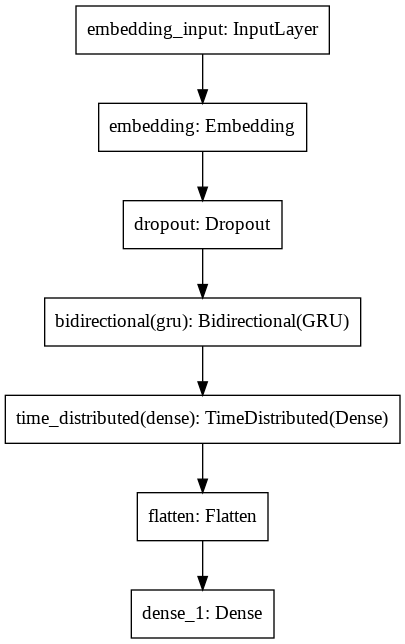

In [0]:
bigru_model_ob = tf.keras.Sequential()
bigru_model_ob.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
bigru_model_ob.add(tf.keras.layers.Dropout(drop_rate))
bigru_model_ob.add(tf.keras.layers.Bidirectional(GRU(units=n_units, return_sequences=True)))
bigru_model_ob.add(tf.keras.layers.TimeDistributed(Dense(10, activation="relu")))
bigru_model_ob.add(tf.keras.layers.Flatten())
bigru_model_ob.add(tf.keras.layers.Dense(1, activation="sigmoid"))

bigru_model_ob.compile(optimizer=optimizer, loss=loss, metrics=metrics)

plot_model(bigru_model_ob, to_file=filepath+'/bigru_model.png')

In [0]:
bigru_model_history_ob = bigru_model_ob.fit(X_train_ob, np.array(y_train_overbudget), batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
26/26 [==============================] - 1s 42ms/step - loss: 0.6831 - accuracy: 0.5537 - val_loss: 0.8531 - val_accuracy: 0.0000e+00
Epoch 2/10
26/26 [==============================] - 0s 14ms/step - loss: 0.5903 - accuracy: 0.7073 - val_loss: 0.5859 - val_accuracy: 0.6957
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: 0.2738 - accuracy: 0.8841 - val_loss: 0.4257 - val_accuracy: 0.9239
Epoch 4/10
26/26 [==============================] - 0s 14ms/step - loss: 0.1302 - accuracy: 0.9512 - val_loss: 0.3351 - val_accuracy: 0.9457
Epoch 5/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0858 - accuracy: 0.9646 - val_loss: 0.3482 - val_accuracy: 0.9457
Epoch 6/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0746 - accuracy: 0.9671 - val_loss: 0.3947 - val_accuracy: 0.9457
Epoch 7/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0879 - accuracy: 0.9744 - val_loss: 0.3356 - val_accuracy: 0.9457
Epoch 8/1

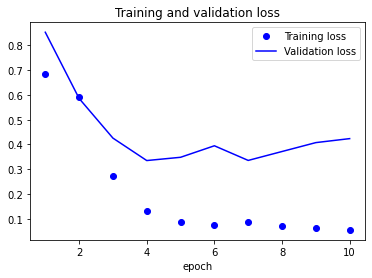

In [0]:
plot_training_history(bigru_model_history_ob)

In [0]:
overbudget_scores = bigru_model_ob.evaluate(X_test_ob, y_test_overbudget)
print("Test Accuracy: %.2f%%" % (overbudget_scores[1]*100))

13/13 [==============================] - 0s 4ms/step - loss: 0.1537 - accuracy: 0.9510
Test Accuracy: 95.10%


In [0]:
overbudget_binary_predictions = bigru_model_ob.predict(X_test_ob)

not_ob, is_ob = [], [] 
for i in range(0,len(overbudget_binary_predictions)):
  #print("%.2f" % overbudget_binary_predictions[i])
  if overbudget_binary_predictions[i] > 0.5:
    is_ob.append(overbudget_binary_predictions[i])
  else:
    not_ob.append(overbudget_binary_predictions[i])

print("Predictions:\nOver Budget:     %s (%.2f%%)\nNot Over Budget: %s (%.2f%%)" % (len(is_ob),(len(is_ob)/len(X_test_overbudget)*100), len(not_ob), (len(not_ob)/len(X_test_overbudget)*100),))

Predictions:
Over Budget:     270 (66.18%)
Not Over Budget: 138 (33.82%)


In [0]:
overbudget_binary_predictions = np.round(overbudget_binary_predictions,0)

print('Overbudget Classification Report \n')
print(classification_report(y_test_overbudget, overbudget_binary_predictions))

cm= confusion_matrix(y_test_overbudget, overbudget_binary_predictions)
cm = pd.DataFrame(cm, columns=['On Budget', "Over Budget"], index = ['On Budget', 'Over Budget'])

print('Overbudget Confusion Matrix \n')
display(cm)
print ('This model has:', cm.loc["On Budget","On Budget"]+cm.loc["Over Budget","Over Budget"],'correct predictions')
print ('This model has:', cm.loc["On Budget","Over Budget"]+cm.loc["Over Budget","On Budget"],'incorrect predictions')

Overbudget Classification Report 

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       126
         1.0       0.99      0.94      0.96       282

    accuracy                           0.95       408
   macro avg       0.93      0.96      0.94       408
weighted avg       0.95      0.95      0.95       408

Overbudget Confusion Matrix 



,On Budget,Over Budget
On Budget,122,4
Over Budget,16,266


This model has: 388 correct predictions
This model has: 20 incorrect predictions


Our BiGRU model for predicting whether a project is overbudget has a high weighted accuracy score, but when it makes an incorrect prediction, it tends to predict that a project is on budget when it is actually overbudget (higher false negative rate).  

- Bidirectional Gated Recurrent Unit RNN for OVER SCHEDULE
  - Binary flag 0/1

In [0]:
#### OVERSCHEDULE

tokenizer = Tokenizer(num_words=n_words)

tokenizer.fit_on_texts(X_train_overschedule)

X_train_encoded_overschedule = tokenizer.texts_to_sequences(X_train_overschedule)
X_test_encoded_overschedule = tokenizer.texts_to_sequences(X_test_overschedule)

max_len = 12
X_train_os = pad_sequences(X_train_encoded_overschedule, maxlen=max_len)
X_test_os = pad_sequences(X_test_encoded_overschedule, maxlen=max_len)

bigru_model_os = tf.keras.Sequential()
bigru_model_os.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
bigru_model_os.add(tf.keras.layers.Dropout(drop_rate))
bigru_model_os.add(tf.keras.layers.Bidirectional(GRU(units=n_units, return_sequences=True)))
bigru_model_os.add(tf.keras.layers.TimeDistributed(Dense(10, activation="relu")))
bigru_model_os.add(tf.keras.layers.Flatten())
bigru_model_os.add(tf.keras.layers.Dense(1, activation="sigmoid"))

bigru_model_os.compile(optimizer=optimizer, loss=loss, metrics=metrics)

bigru_model_os.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 50)            26050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 12, 200)           91200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 10)            2010      
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 119,381
Trainable params: 119,381
Non-trainable params: 0
________________________________________________

In [0]:
bigru_model_history_os = bigru_model_os.fit(X_train_os, np.array(y_train_overschedule), batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
19/19 [==============================] - 1s 49ms/step - loss: 0.6855 - accuracy: 0.5643 - val_loss: 0.7538 - val_accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 0s 14ms/step - loss: 0.6213 - accuracy: 0.6611 - val_loss: 0.6312 - val_accuracy: 0.7463
Epoch 3/10
19/19 [==============================] - 0s 14ms/step - loss: 0.3423 - accuracy: 0.8898 - val_loss: 0.3764 - val_accuracy: 0.8955
Epoch 4/10
19/19 [==============================] - 0s 15ms/step - loss: 0.1499 - accuracy: 0.9449 - val_loss: 0.1015 - val_accuracy: 0.9701
Epoch 5/10
19/19 [==============================] - 0s 14ms/step - loss: 0.0783 - accuracy: 0.9750 - val_loss: 0.1279 - val_accuracy: 0.9552
Epoch 6/10
19/19 [==============================] - 0s 14ms/step - loss: 0.0455 - accuracy: 0.9866 - val_loss: 0.1685 - val_accuracy: 0.9701
Epoch 7/10
19/19 [==============================] - 0s 14ms/step - loss: 0.0351 - accuracy: 0.9917 - val_loss: 0.2344 - val_accuracy: 0.9403
Epoch 8/1

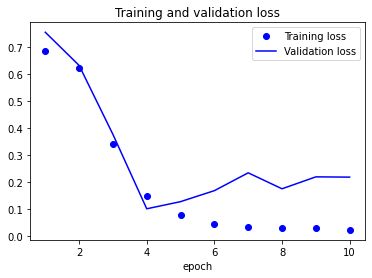

In [0]:
plot_training_history(bigru_model_history_os)

In [0]:
overschedule_scores = bigru_model_os.evaluate(X_test_os, y_test_overschedule)
print("Test Accuracy: %.2f%%" % (overschedule_scores[1]*100))

13/13 [==============================] - 0s 4ms/step - loss: 0.3056 - accuracy: 0.9412
Test Accuracy: 94.12%


In [0]:
overschedule_binary_predictions = bigru_model_os.predict(X_test_os)

overschedule_binary_predictions.shape

not_os, is_os = [], [] 
for i in range(0,len(overschedule_binary_predictions)):
  #print("%.2f" % overschedule_binary_predictions[i])
  if overschedule_binary_predictions[i] > 0.5:
    is_os.append(overschedule_binary_predictions[i])
  else:
    not_os.append(overschedule_binary_predictions[i])

print("Predictions:\nOver Schedule:     %s (%.2f%%)\nNot Over Schedule: %s (%.2f%%)" % (len(is_os),(len(is_os)/len(X_test_overschedule)*100), len(not_os), (len(not_os)/len(X_test_overschedule)*100),))

Predictions:
Over Schedule:     307 (75.25%)
Not Over Schedule: 101 (24.75%)


In [0]:
overschedule_binary_predictions = np.round(overschedule_binary_predictions,0)

print('Overschedule Classification Report \n')
print(classification_report(y_test_overschedule, overschedule_binary_predictions))

cm= confusion_matrix(y_test_overschedule, overschedule_binary_predictions)
cm = pd.DataFrame(cm, columns=['On Schedule', "Over Schedule"], index = ['On Schedule', 'Over Schedule'])

print('Overschedule Confusion Matrix \n')
display(cm)
print ('This model has:', cm.loc["On Schedule","On Schedule"]+cm.loc["Over Schedule","Over Schedule"],'correct predictions')
print ('This model has:', cm.loc["On Schedule","Over Schedule"]+cm.loc["Over Schedule","On Schedule"],'incorrect predictions')

Overschedule Classification Report 

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87        85
         1.0       0.99      0.94      0.96       323

    accuracy                           0.94       408
   macro avg       0.89      0.95      0.92       408
weighted avg       0.95      0.94      0.94       408

Overschedule Confusion Matrix 



,On Schedule,Over Schedule
On Schedule,81,4
Over Schedule,20,303


This model has: 384 correct predictions
This model has: 24 incorrect predictions


Our BiGRU model for predicting whether a project is overschedule has a high weighted accuracy score, but when it makes an incorrect prediction, it tends to predict that a project is on schedule when it is actually overschedule (higher false negative rate).  

# -----------------------------------------------------------------------------------------------------------------

#3 - Linear Regression Models

Budget APE Linear Regression Model using all predictor variables

In [0]:
# BUDGET ALL VARIABLE MODEL PREDICTORS
budget_response_variable= 'Budget_Absoulte_Error'

budget_all_vars = df_augmented.columns.to_list()

remove_vars = ['Date_Reported_As_Of','Design_Start','Forecast_Completion',
               'Budget_Actual', 'Budget_Absoulte_Error', 'Schedule_Actual']
for r in remove_vars:
  budget_all_vars.remove(str(r))


- Build a Baseline Model:

In [0]:
print("Selected Independent Variables: \n", budget_all_vars)

# Assign Dependent y variable
y_train_budget = train[budget_response_variable]
y_test_budget = test[budget_response_variable]

# add polynomial features - citing CS109A HW3 Solution notebook
def add_poly_features(dataset, degree, columns, interact_left, interact_right):

    # Make a copy of the dataset
    poly_dataset = dataset.copy()
    
    # Use this to generate the polynomial terms
    maker = PolynomialFeatures(degree, include_bias=False)
        
    # Loop over each column we want to generate polynomials terms for
    for cur_col in columns:
        # Create the polynomial terms
        poly_values = maker.fit_transform(poly_dataset[[cur_col]])
        
        # Get the new column names
        poly_names = maker.get_feature_names([cur_col])
        
        # Add the new columns back to the original dataframe copy
        to_add = pd.DataFrame(poly_values[:,1:], 
                              index=poly_dataset.index, 
                              columns=poly_names[1:])
        
        poly_dataset = pd.concat([poly_dataset, to_add], axis=1)

        # Loop over all the left interactions
        for left_name in interact_left:
            left_column = poly_dataset[left_name]
            
            # For each left interaction column, create an interaction
            # with each column in the right interaction list.
            for right_name in interact_right:
                right_column = poly_dataset[right_name]
                combined_name = "{}*{}".format(left_name, right_name)
                poly_dataset[combined_name] = left_column*right_column

    return poly_dataset

def build_model_data(train, test,x_pred, degree, poly_col, interact_left, interact_right, model):
    #Predictors
    train = train[x_pred] #unpack predictor list
    test = test[x_pred] #unpack predictor list

    train_colname = train.columns
    train_idxname = train.index
    test_colname = test.columns
    test_idxname = test.index

    train=train.astype(float)
    test=test.astype(float)

    scaler = StandardScaler().fit(train) #standardize the training dataset

    train = scaler.transform(train)
    test = scaler.transform(test)

    train = pd.DataFrame(train, columns = train_colname, index=train_idxname)
    test = pd.DataFrame(test, columns = test_colname, index=test_idxname)

    train = add_poly_features(train, degree, poly_col, interact_left, interact_right)
    test = add_poly_features(test, degree, poly_col, interact_left, interact_right)

    # add a constant if using StatModels OLS
    if model == "OLS":
      train = sm.add_constant(train)
      test = sm.add_constant(test, has_constant='add')

    return train, test

degree = 1 # order for polynomial model
poly_col = []  
interact_left = [] 
interact_right = []

# "Budget Absolute Error" All Variables Least Squares Regression Model 
train_transformed, test_transformed  = build_model_data(train, test, budget_all_vars, degree, poly_col, interact_left, interact_right, "OLS")

y_train_budget = y_train_budget.astype(float)
y_test_budget = y_test_budget.astype(float)

budget_fitted_model_all = OLS(endog= y_train_budget, exog=train_transformed, hasconst=True).fit()
budget_fitted_model_predictions = budget_fitted_model_all.predict(test_transformed)

display(budget_fitted_model_all.summary())


print("All Variables OLS Model: TRAIN R^2 SCORE %0.03f" % budget_fitted_model_all.rsquared)

Selected Independent Variables: 
 ['Budget_Forecast', 'Latest_Budget_Changes', 'Total_Budget_Changes', 'Latest_Schedule_Changes', 'Total_Schedule_Changes', 'Total_Days', 'Current_Phase_Construction Procurement', 'Current_Phase_Design', 'Category_Bridges', 'Category_Bridges, Streets and Roadways', 'Category_Ferries', 'Category_Health and Hospitals', 'Category_Industrial Development', 'Category_Industrial Development, Streets and Roadways', 'Category_Other Government Facilities', 'Category_Parks', 'Category_Public Safety and Criminal Justice', 'Category_Sanitation', 'Category_Schools', 'Category_Sewers', 'Category_Streets and Roadways', 'Category_Wastewater Treatment', 'Category_Water Supply', 'Borough_Brooklyn', 'Borough_Carmel', 'Borough_Citywide', 'Borough_Manhattan', 'Borough_Marlboro', 'Borough_New York', 'Borough_Olive', 'Borough_Port Jervis', 'Borough_Queens', 'Borough_Staten Island', 'Borough_Upstate', 'Borough_Valhalla', 'Managing_Agency_DDC', 'Managing_Agency_DEP', 'Managing_Ag

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Budget_Absoulte_Error   R-squared:                       0.668
Model:                               OLS   Adj. R-squared:                  0.054
Method:                    Least Squares   F-statistic:                     1.088
Date:                   Sun, 10 May 2020   Prob (F-statistic):              0.405
Time:                           07:27:17   Log-Likelihood:                 40.194
No. Observations:                     95   AIC:                             43.61
Df Residuals:                         33   BIC:                             202.0
Df Model:                             61                                         
Covariance Type:               nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.2659      0.028      9.639      0.000       0.210       0.322
Budget_Forecast                                          -0.0717      0.055     -1.307      0.200      -0.183       0.040
Latest_Budget_Changes                                     0.5954      0.322      1.847      0.074      -0.061       1.251
Total_Budget_Changes                                     -0.0552      0.133     -0.416      0.680      -0.325       0.215
Latest_Schedule_Changes                                  -0.0635      0.070     -0.904      0.373      -0.207       0.079
Total_Schedule_Changes                                    0.1969      0.155      1.271      0.213      -0.118       0.512
Total_Days                                               -0.0130      0.089     -0.146      0.885      -0.194       0.168
Current_Phase_Construction Procurement                    0.0029      0.053      0.054      0.957      -0.106       0.112
Current_Phase_Design                                      0.0353      0.072      0.487      0.629      -0.112       0.183
Category_Bridges                                          0.0626      0.039      1.586      0.122      -0.018       0.143
Category_Bridges, Streets and Roadways                -3.251e-14   1.76e-14     -1.842      0.074   -6.84e-14    3.39e-15
Category_Ferries                                         -0.2544      0.148     -1.724      0.094      -0.555       0.046
Category_Health and Hospitals                            -0.4412      0.245     -1.798      0.081      -0.940       0.058
Category_Industrial Development                           0.2715      0.169      1.605      0.118      -0.073       0.616
Category_Industrial Development, Streets and Roadways  1.163e-14   6.19e-15      1.878      0.069   -9.72e-16    2.42e-14
Category_Other Government Facilities                     -0.3863      0.230     -1.677      0.103      -0.855       0.082
Category_Parks                                           -0.2932      0.186     -1.577      0.124      -0.671       0.085
Category_Public Safety and Criminal Justice              -0.4481      0.220     -2.034      0.050      -0.896    2.39e-05
Category_Sanitation                                      -0.5111      0.279     -1.834      0.076      -1.078       0.056
Category_Schools                                         -0.5307      0.297     -1.789      0.083      -1.134       0.073
Category_Sewers                                           0.3201      0.165      1.942      0.061      -0.015       0.656
Category_Streets and Roadways                             0.2983      0.166      1.800      0.081      -0.039       0.635


All Variables OLS Model: TRAIN R^2 SCORE 0.668


We check to see if the model has problems with multicollinearity by checking the Variance Inflation Factor (VIF) for all predictor variables.  Predictor Variables with VIF greater than 10 will be removed in the baseline linear regression model. 

In [0]:
pd.set_option("max_rows", None)

Budget_VIF = pd.Series([variance_inflation_factor(train_transformed.values, i) 
               for i in range(train_transformed.shape[1])], 
              index=train_transformed.columns)

Budget_VIF.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                        1.000000
Budget_Forecast              3.954154
Latest_Budget_Changes      136.592133
Total_Budget_Changes        23.094113
Latest_Schedule_Changes      6.488764
dtype: float64

We also check a lasso regularized model to see which predictor variables have a coefficient of zero after lasso regularization.  These predictor variables will also be removed from the baseline linear regression model.

In [0]:
fitted_model = Lasso(alpha=0.01).fit(train_transformed, y_train_budget)

fitted_model.coef_
lasso_coeff = pd.DataFrame([fitted_model.coef_],columns=train_transformed.columns,index=['Lambda']).transpose()
lasso_coeff.head()

,Lambda
const,0.000000
Budget_Forecast,-0.046246
Latest_Budget_Changes,-0.000000
Total_Budget_Changes,-0.012689
Latest_Schedule_Changes,-0.035228


We continue to remove predictor variables from the linear regression model until the remaining predictor variables are statistically significant. 

In [0]:
# BUDGET BASELINE MODEL PREDICTORS

budget_baseline_vars = df_augmented.columns.to_list()

remove_vars = ['Date_Reported_As_Of','Design_Start','Forecast_Completion',
               'Budget_Actual', 'Budget_Absoulte_Error', 'Schedule_Actual', 
               'Schedule_Absoulte_Error', 'Current_Phase_Construction Procurement', 
               'Budget_Forecast','Category_Other Government Facilities',
               'Category_Industrial Development', 'Category_Ferries', 'Total_Days',
               'Category_Health and Hospitals', 'Managing_Agency_DEP',
               'Category_Bridges, Streets and Roadways', 'Borough_Queens',
               'Borough_Upstate','Client_Agency_DEP, DOT', 'Managing_Agency_DOC',
               'Client_Agency_DOC',"Client_Agency_DOT, Mayor's Office",
               'Client_Agency_H+H','Client_Agency_DSBS','Client_Agency_NYPD',
               'Client_Agency_ORR','Latest_Budget_Changes','Category_Sanitation',
               'Category_Wastewater Treatment','Borough_Marlboro','Client_Agency_DEP, EDC',
               'Borough_Staten Island','Client_Agency_DSNY','Category_Schools',
               'Managing_Agency_SCA','Client_Agency_DOE','Client_Agency_EDC',
               'Project Type_Park','Divison_8','Divison_4','Project Type_Civil',
               'Managing_Agency_DSNY','Managing_Agency_EDC','Category_Bridges',
               'Category_Parks','Borough_Olive','Client_Agency_DEP, DOT, EDC',
               'Client_Agency_FDNY','Site Storage_2','Borough_Carmel',
               'Client_Agency_DPR','Category_Water Supply','Category_Industrial Development, Streets and Roadways',
               'Client_Agency_DEP','Client_Agency_BWT','Borough_Brooklyn',
               'Client_Agency_DCLA','Divison_7','Divison_0','Category_Sewers',
               'Divison_12','Borough_New York','Borough_Citywide',
               'Project Type_Street','Scope_5.0','Scope_4.0','Scope_7.0',
               'Scope_0','Scope_6.0','Borough_Manhattan','Borough_Port Jervis','Borough_Valhalla',
               'Total_Budget_Changes','Current_Phase_Design']

               
for r in remove_vars:
  budget_baseline_vars.remove(str(r))

    

In [0]:
print("Selected Independent Variables: \n", budget_baseline_vars)
print("")

degree = 1
poly_col = budget_baseline_vars
interact_left = []
interact_right = []

# "Budget Absolute Error" Baseline Least Squares Regression Model 
train_transformed, test_transformed  = build_model_data(train, test, budget_baseline_vars, degree, poly_col, interact_left, interact_right, "OLS")
transformed = train_transformed.append(test_transformed)
y_combined_budget = y_train_budget.append(y_test_budget)

budget_fitted_model_baseline = OLS(endog= y_train_budget, exog=train_transformed, hasconst=True).fit()
budget_fitted_model_y_pred_train = budget_fitted_model_baseline.predict(train_transformed)
budget_fitted_model_test_predictions = budget_fitted_model_baseline.predict(test_transformed)
budget_fitted_model_all_predictions = budget_fitted_model_baseline.predict(transformed)

display(budget_fitted_model_baseline.summary())

# r2_score
print("Baseline MLR Model: TRAIN R^2 SCORE %0.03f" % budget_fitted_model_baseline.rsquared)

Selected Independent Variables: 
 ['Latest_Schedule_Changes', 'Total_Schedule_Changes', 'Category_Public Safety and Criminal Justice', 'Category_Streets and Roadways', 'Managing_Agency_DDC', 'Client_Agency_DCAS', 'Client_Agency_DOT', "Client_Agency_Mayor's Office", 'Site Storage_1']



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Budget_Absoulte_Error   R-squared:                       0.335
Model:                               OLS   Adj. R-squared:                  0.265
Method:                    Least Squares   F-statistic:                     4.764
Date:                   Sun, 10 May 2020   Prob (F-statistic):           3.84e-05
Time:                           07:27:18   Log-Likelihood:                 7.2443
No. Observations:                     95   AIC:                             5.511
Df Residuals:                         85   BIC:                             31.05
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           0.2659      0.024     10.936      0.000       0.218       0.314
Latest_Schedule_Changes                        -0.0638      0.029     -2.201      0.030      -0.121      -0.006
Total_Schedule_Changes                          0.0839      0.027      3.120      0.002       0.030       0.137
Category_Public Safety and Criminal Justice    -0.0604      0.029     -2.099      0.039      -0.118      -0.003
Category_Streets and Roadways                   0.1039      0.045      2.330      0.022       0.015       0.193
Managing_Agency_DDC                             0.0649      0.027      2.413      0.018       0.011       0.118
Client_Agency_DCAS                              0.0623      0.026      2.397      0.019       0.011       0.114
Client_Agency_DOT                              -0.0865      0.046     -1.877      0.064      -0.178       0.005
Client_Agency_Mayor's Office                    0.0627      0.025      2.556      0.012       0.014       0.111
Site Storage_1                                 -0.0576      0.025     -2.321      0.023      -0.107      -0.008
==============================================================================
Omnibus:                       40.519   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.407
Skew:                           1.502   Prob(JB):                     1.75e-24
Kurtosis:                       7.315   Cond. No.                         3.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Baseline MLR Model: TRAIN R^2 SCORE 0.335


In [0]:
print("Budget Baseline Model Train RMSE:", np.round(mean_squared_error(y_train_budget, budget_fitted_model_y_pred_train, squared=True),2))
print("Budget Baseline Model Test RMSE:", np.round(mean_squared_error(y_test_budget, budget_fitted_model_test_predictions, squared=True),2))

Budget Baseline Model Train RMSE: 0.05
Budget Baseline Model Test RMSE: 0.12


We conducted a gridsearch for optimal alphas and polynomial degrees for ridge and lasso regularization.  After reviewing the results, we decided that it was not necessary to implement ridge or lasso regularization because our linear regression models are not overfit with the limited observations in our dataset.

In [0]:
# Ridge 

# Citing CS109A HW3 Notebook for code reference

alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])
degrees = range(1,5)

# Arrays to hold our scores
train_r2s = np.zeros((len(degrees),len(alphas)))
val_r2s = np.zeros((len(degrees),len(alphas)))

# Loop over each degree
for cur_row, cur_degree in enumerate(degrees):

    # Get the  design matrix
    train_transformed, test_transformed  = build_model_data(train, test, budget_baseline_vars, 
                                                            cur_degree, poly_col, interact_left, interact_right, "Ridge")
    
    # Loop over each alpha value
    for cur_col, cur_alpha in enumerate(alphas):

        # Fit and Score
        fitted_model = Ridge(alpha=cur_alpha).fit(train_transformed, y_train_budget)
        
        # Get predictions on the test set
        y_test_hat = fitted_model.predict(test_transformed)

        # Store results
        train_r2s[cur_row,cur_col] = fitted_model.score(train_transformed, y_train_budget)
        val_r2s[cur_row,cur_col] = r2_score(y_test_budget, y_test_hat)
                    
print("Training Set Performance")
display(pd.DataFrame(train_r2s, index = degrees, columns = alphas))

Training Set Performance


,0.01,0.05,0.10,0.50,1.00,5.00,10.00,50.00,100.00
1,0.335279,0.335278,0.335276,0.335224,0.335069,0.331482,0.324173,0.261855,0.209864
2,0.336466,0.336466,0.336465,0.336455,0.336422,0.335520,0.333287,0.306881,0.280964
3,0.339963,0.339963,0.339962,0.339933,0.339851,0.338101,0.334931,0.314210,0.299523
4,0.340078,0.340078,0.340077,0.340046,0.339960,0.338172,0.335035,0.315371,0.301630


In [0]:
# Lasso

alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])
degrees = range(1,5)

# Arrays to hold our scores
train_r2s = np.zeros((len(degrees),len(alphas)))
val_r2s = np.zeros((len(degrees),len(alphas)))

# Loop over each degree
for cur_row, cur_degree in enumerate(degrees):

    # Get the  design matrix
    train_transformed, test_transformed  = build_model_data(train, test, budget_baseline_vars, 
                                                            cur_degree, poly_col, interact_left, interact_right, "Lasso")
   
    # Loop over each alpha value
    for cur_col, cur_alpha in enumerate(alphas):

        # Fit and Score
        fitted_model = Lasso(alpha=cur_alpha).fit(train_transformed, y_train_budget)
        
        # Get predictions on the test set
        y_test_hat = fitted_model.predict(test_transformed)

        # Store results
        train_r2s[cur_row,cur_col] = fitted_model.score(train_transformed, y_train_budget)
        val_r2s[cur_row,cur_col] = r2_score(y_test_budget, y_test_hat)
                    
print("Training Set Performance")
display(pd.DataFrame(train_r2s, index = degrees, columns = alphas))

train_transformed, test_transformed  = build_model_data(train, test, budget_baseline_vars, 1, poly_col, interact_left, interact_right, "Lasso")

Training Set Performance


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036461974533832375, tolerance: 0.0007184143227511354
  positive)


,0.01,0.05,0.10,0.50,1.00,5.00,10.00,50.00,100.00
1,0.304429,0.067073,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
2,0.324729,0.174321,0.139570,0.011007,0.000000,0.000000,0.00000,0.000000,0.0
3,0.326424,0.227946,0.184383,0.114169,0.063187,0.008722,0.00000,0.000000,0.0
4,0.326172,0.237720,0.209947,0.178776,0.151907,0.071536,0.04531,0.006283,0.0


- Model Diagnostics:

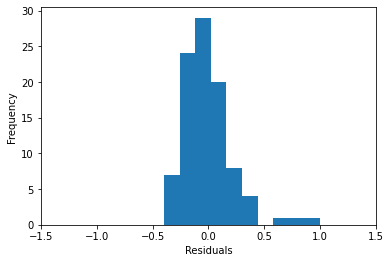

In [0]:
# histogram of residuals
budget_resid = budget_fitted_model_baseline.resid
plt.xlim(-1.5,1.5)
plt.hist(budget_resid)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The residual histogram plot is slightly skewed to the right.

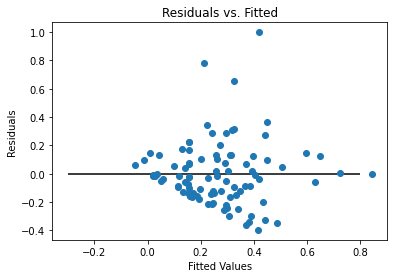

In [0]:
# Plot of residuals vs. fitted 
plt.plot(budget_fitted_model_baseline.fittedvalues, budget_fitted_model_baseline.resid, 'o')
plt.hlines(xmin=-0.3, xmax=0.8, y=0)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

We observe strong signs of heteroskedasticity in this linear model.  Unfortunately we don't think it can be easily fixed because the independent variable 'y' is the error in our guess and that guess is much wider in variance as the value of budget or schedule get larger.  It's worth noting that budget and schedule are two parts of the project trinity and assumes that scope stays fixed.

As a result, budget and schedule will always be somehow related to one another (it's possible to figure out an approximate budget from an approximate schedule based on a similar project).  Consequently, the amount in error in our guess can be directly related to our guess itself.  

The only way to practically correct for heteroskedasticity is to add additional scope information.

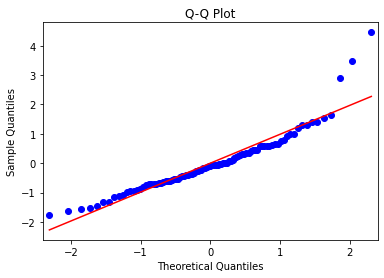

In [0]:
fig = sm.qqplot(budget_resid, fit=True, line='r')
plt.title('Q-Q Plot')
plt.show()

We observe a right-skewed distribution in the qq plot.  However, the observations are generally linear in the -1 to 1 theoretical quantile range so we can still consider the observations to be normally distributed.

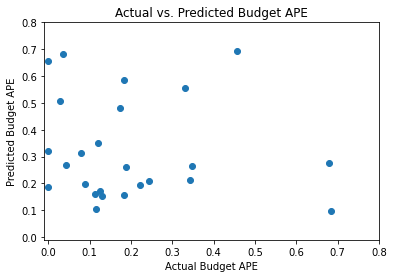

In [0]:
plt.scatter(y_test_budget, budget_fitted_model_test_predictions)
plt.xlabel("Actual Budget APE")
plt.ylabel("Predicted Budget APE")
plt.title("Actual vs. Predicted Budget APE")
plt.xlim(-0.01,0.8)
plt.ylim(-0.01,0.8)
plt.show()

Schedule APE Linear Regression Model

In [0]:
# ALL VARIABLES SCHEDULE MODEL PREDICTORS
schedule_response_variable= 'Schedule_Absoulte_Error'

schedule_all_vars = df_augmented.columns.to_list()

remove_vars = ['Date_Reported_As_Of','Design_Start','Forecast_Completion',
               'Budget_Absoulte_Error', 'Schedule_Actual', 
               'Schedule_Absoulte_Error', 'Total_Days','Latest_Schedule_Changes','Total_Schedule_Changes']
for r in remove_vars:
  schedule_all_vars.remove(str(r))


In [0]:
print("Selected Independent Variables: \n", schedule_all_vars)

# Assign Dependent y variable
y_train_schedule = train[schedule_response_variable]
y_test_schedule = test[schedule_response_variable]

degree = 1
poly_col = []
interact_left = []
interact_right = []

# "Schedule Absolute Error" All Variables Least Squares Regression Model 
train_transformed, test_transformed  = build_model_data(train, test, schedule_all_vars, degree, poly_col, interact_left, interact_right, "OLS")
transformed = train_transformed.append(test_transformed)

y_train_schedule = y_train_schedule.astype(float)
y_test_schedule = y_test_schedule.astype(float)

schedule_fitted_model_all = OLS(endog= y_train_schedule, exog=train_transformed, hasconst=True).fit()
schedule_fitted_model_test_predictions = schedule_fitted_model_all.predict(test_transformed)

display(schedule_fitted_model_all.summary())

# r2_score()
print("Baseline MLR Model: TRAIN R^2 SCORE %0.03f" % schedule_fitted_model_all.rsquared)

Selected Independent Variables: 
 ['Budget_Forecast', 'Latest_Budget_Changes', 'Total_Budget_Changes', 'Current_Phase_Construction Procurement', 'Current_Phase_Design', 'Category_Bridges', 'Category_Bridges, Streets and Roadways', 'Category_Ferries', 'Category_Health and Hospitals', 'Category_Industrial Development', 'Category_Industrial Development, Streets and Roadways', 'Category_Other Government Facilities', 'Category_Parks', 'Category_Public Safety and Criminal Justice', 'Category_Sanitation', 'Category_Schools', 'Category_Sewers', 'Category_Streets and Roadways', 'Category_Wastewater Treatment', 'Category_Water Supply', 'Borough_Brooklyn', 'Borough_Carmel', 'Borough_Citywide', 'Borough_Manhattan', 'Borough_Marlboro', 'Borough_New York', 'Borough_Olive', 'Borough_Port Jervis', 'Borough_Queens', 'Borough_Staten Island', 'Borough_Upstate', 'Borough_Valhalla', 'Managing_Agency_DDC', 'Managing_Agency_DEP', 'Managing_Agency_DOC', 'Managing_Agency_DSNY', 'Managing_Agency_EDC', 'Managing

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Schedule_Absoulte_Error   R-squared:                       0.718
Model:                                 OLS   Adj. R-squared:                  0.284
Method:                      Least Squares   F-statistic:                     1.655
Date:                     Sun, 10 May 2020   Prob (F-statistic):             0.0526
Time:                             07:27:19   Log-Likelihood:                 90.935
No. Observations:                       95   AIC:                            -65.87
Df Residuals:                           37   BIC:                             82.25
Df Model:                               57                                         
Covariance Type:                 nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.2474      0.015     16.200      0.000       0.216       0.278
Budget_Forecast                                           0.0137      0.021      0.640      0.526      -0.030       0.057
Latest_Budget_Changes                                    -0.2487      0.147     -1.690      0.099      -0.547       0.050
Total_Budget_Changes                                      0.0447      0.067      0.669      0.508      -0.091       0.180
Current_Phase_Construction Procurement                    0.0314      0.028      1.136      0.263      -0.025       0.087
Current_Phase_Design                                      0.0840      0.033      2.509      0.017       0.016       0.152
Category_Bridges                                         -0.0128      0.019     -0.657      0.516      -0.052       0.027
Category_Bridges, Streets and Roadways                -1.133e-14   9.56e-15     -1.185      0.243   -3.07e-14    8.04e-15
Category_Ferries                                          0.0630      0.068      0.927      0.360      -0.075       0.201
Category_Health and Hospitals                             0.1323      0.115      1.151      0.257      -0.101       0.365
Category_Industrial Development                          -0.1208      0.083     -1.450      0.156      -0.290       0.048
Category_Industrial Development, Streets and Roadways  3.871e-16   3.31e-16      1.170      0.250   -2.83e-16    1.06e-15
Category_Other Government Facilities                      0.1351      0.109      1.245      0.221      -0.085       0.355
Category_Parks                                            0.1069      0.086      1.237      0.224      -0.068       0.282
Category_Public Safety and Criminal Justice               0.1249      0.107      1.167      0.251      -0.092       0.342
Category_Sanitation                                       0.1392      0.131      1.061      0.296      -0.127       0.405
Category_Schools                                          0.1264      0.134      0.940      0.353      -0.146       0.399
Category_Sewers                                          -0.1185      0.079     -1.501      0.142      -0.278       0.041
Category_Streets and Roadways                            -0.0874      0.074     -1.176      0.247      -0.238       0.063
Category_Wastewater Treatment                            -0.0476      0.119     -0.401      0.691      -0.288       0.193
Category_Water Supply                                    -0.1030      0.102     -1.013      0.317      -0.309       0.103
Borough_Brooklyn                                          0.0362      0.043      0.848      0.402   

Baseline MLR Model: TRAIN R^2 SCORE 0.718


Similar to the budget linear regression model, we check for predictor variables with high VIF values to avoid problems with multicollinearity in the schedule baseline linear regression model as well as check the lasso regularization model for predictor variables with zero weights.

In [0]:
Schedule_VIF = pd.Series([variance_inflation_factor(train_transformed.values, i) 
               for i in range(train_transformed.shape[1])], 
              index=train_transformed.columns)

Schedule_VIF.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                                      1.000000
Budget_Forecast                                 inf
Latest_Budget_Changes                     92.843887
Total_Budget_Changes                            inf
Current_Phase_Construction Procurement     3.275888
dtype: float64

In [0]:
fitted_model = Lasso(alpha=0.01).fit(train_transformed, y_train_schedule)

fitted_model.coef_
lasso_coeff = pd.DataFrame([fitted_model.coef_],columns=train_transformed.columns,index=['Lambda']).transpose()
lasso_coeff.head()

,Lambda
const,0.000000
Budget_Forecast,0.000000
Latest_Budget_Changes,0.000000
Total_Budget_Changes,0.016125
Current_Phase_Construction Procurement,-0.000000


We remove the predictor variables with high VIF, variables that were identified by lasso regularization to have zero weights, and other predictor variables which were determined not to be stastically significant to produce the schedule baseline linear regression model.

In [0]:
# SCHEDULE BASELINE MODEL PREDICTORS
schedule_model_response_variable= 'Schedule_Absoulte_Error'

schedule_baseline_vars = df_augmented.columns.to_list()

remove_vars = ['Date_Reported_As_Of','Design_Start','Forecast_Completion',
               'Budget_Actual', 'Budget_Absoulte_Error', 'Schedule_Actual', 
               'Schedule_Absoulte_Error','Total_Days','Latest_Schedule_Changes','Total_Schedule_Changes',
               "Client_Agency_DOT, Mayor's Office",'Current_Phase_Construction Procurement',
               'Total_Budget_Changes','Category_Industrial Development','Borough_Carmel',
               'Scope_6.0','Managing_Agency_DDC','Borough_Staten Island','Borough_Queens',
               'Category_Water Supply',"Client_Agency_Mayor's Office",'Borough_Manhattan',
               'Borough_Marlboro','Latest_Budget_Changes',
               'Divison_7','Divison_0','Category_Bridges, Streets and Roadways',
               'Category_Sewers','Category_Wastewater Treatment','Borough_Port Jervis',
               'Budget_Forecast','Category_Bridges','Client_Agency_DEP, EDC',
               'Borough_Valhalla','Category_Industrial Development, Streets and Roadways',
               'Borough_Olive','Borough_Upstate','Borough_Brooklyn','Scope_7.0',
               'Project Type_Civil','Scope_0','Scope_5.0','Site Storage_1','Scope_4.0',
               'Borough_New York','Category_Parks','Project Type_Park','Divison_4',
               'Category_Other Government Facilities','Client_Agency_NYPD',
               'Project Type_Street','Client_Agency_FDNY','Client_Agency_DOC',
               'Client_Agency_DCAS','Managing_Agency_DOC','Managing_Agency_EDC',
               'Borough_Citywide','Managing_Agency_DSNY','Category_Ferries', 'Client_Agency_DSNY',
               'Client_Agency_DSBS','Category_Health and Hospitals','Category_Streets and Roadways',
               'Managing_Agency_DEP','Site Storage_2','Client_Agency_DCLA',
               'Category_Public Safety and Criminal Justice','Client_Agency_BWT',
               'Client_Agency_DOT','Client_Agency_H+H','Divison_12',
               'Client_Agency_DEP, DOT, EDC','Client_Agency_DEP, DOT',
               'Client_Agency_DPR','Client_Agency_EDC']


for r in remove_vars:
  schedule_baseline_vars.remove(str(r))


In [0]:
print("Selected Independent Variables: \n", schedule_baseline_vars)
print("")

degree = 1
poly_col = schedule_baseline_vars
# interact_left = ['Category_Health and Hospitals','Category_Public Safety and Criminal Justice','Category_Sanitation','Category_Schools']
# interact_right = ['Site Storage_2']

interact_left = []
interact_right = []

# "Schedule Absolute Error" All Variables Least Squares Regression Model 
train_transformed, test_transformed  = build_model_data(train, test, schedule_baseline_vars, degree, poly_col, interact_left, interact_right, "OLS")
transformed = train_transformed.append(test_transformed)
y_combined_schedule = y_train_schedule.append(y_test_schedule)

schedule_fitted_model_baseline = OLS(endog= y_train_schedule, exog=train_transformed, hasconst=True).fit()
schedule_fitted_model_y_pred_train = schedule_fitted_model_baseline.predict(train_transformed)
schedule_fitted_model_test_predictions = schedule_fitted_model_baseline.predict(test_transformed)
schedule_fitted_model_all_predictions = schedule_fitted_model_baseline.predict(transformed)

display(schedule_fitted_model_baseline.summary())

# r2_score()
print("Baseline MLR Model: TRAIN R^2 SCORE %0.03f" % schedule_fitted_model_baseline.rsquared)

Selected Independent Variables: 
 ['Current_Phase_Design', 'Category_Sanitation', 'Category_Schools', 'Managing_Agency_SCA', 'Client_Agency_DEP', 'Client_Agency_DOE', 'Client_Agency_ORR', 'Divison_8']



<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Schedule_Absoulte_Error   R-squared:                       0.306
Model:                                 OLS   Adj. R-squared:                  0.258
Method:                      Least Squares   F-statistic:                     6.456
Date:                     Sun, 10 May 2020   Prob (F-statistic):           1.15e-05
Time:                             07:27:20   Log-Likelihood:                 48.084
No. Observations:                       95   AIC:                            -82.17
Df Residuals:                           88   BIC:                            -64.29
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2474      0.016     15.913      0.000       0.217       0.278
Current_Phase_Design     0.0374      0.016      2.355      0.021       0.006       0.069
Category_Sanitation     -0.0314      0.016     -1.931      0.057      -0.064       0.001
Category_Schools        -0.0281      0.006     -4.857      0.000      -0.040      -0.017
Managing_Agency_SCA     -0.0281      0.006     -4.857      0.000      -0.040      -0.017
Client_Agency_DEP       -0.0228      0.018     -1.284      0.203      -0.058       0.013
Client_Agency_DOE       -0.0281      0.006     -4.857      0.000      -0.040      -0.017
Client_Agency_ORR       -0.0348      0.016     -2.208      0.030      -0.066      -0.003
Divison_8               -0.0167      0.016     -1.055      0.294      -0.048       0.015
==============================================================================
Omnibus:                        1.524   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.467   Jarque-Bera (JB):                1.365
Skew:                           0.292   Prob(JB):                        0.505
Kurtosis:                       2.938   Cond. No.                     6.44e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.39e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Baseline MLR Model: TRAIN R^2 SCORE 0.306


Similar to the budget APE linear regression model, we evaluated but decided not to implement ridge or lasso regularization for our schedule APE linear regression model because our linear regression models are not overfit with the limited observations in our dataset.

In [0]:
# Ridge 

alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])
degrees = range(1,5)

# Arrays to hold our scores
train_r2s = np.zeros((len(degrees),len(alphas)))
val_r2s = np.zeros((len(degrees),len(alphas)))

# Loop over each degree
for cur_row, cur_degree in enumerate(degrees):

    # Get the  design matrix
    
    train_transformed, test_transformed  = build_model_data(train, test, schedule_baseline_vars, cur_degree, poly_col, interact_left, interact_right, "Ridge")

    # Loop over each alpha value
    for cur_col, cur_alpha in enumerate(alphas):

        # Fit and Score
        fitted_model = Ridge(alpha=cur_alpha).fit(train_transformed, y_train_schedule)
        
        # Get predictions on the test set
        y_test_hat = fitted_model.predict(test_transformed)

        # Store results
        train_r2s[cur_row,cur_col] = fitted_model.score(train_transformed, y_train_schedule)
        val_r2s[cur_row,cur_col] = r2_score(y_test_schedule, y_test_hat)
                    
print("Training Set Performance")
display(pd.DataFrame(train_r2s, index = degrees, columns = alphas))

Training Set Performance


,0.01,0.05,0.10,0.50,1.00,5.00,10.00,50.00,100.00
1,0.305628,0.305628,0.305627,0.305620,0.305599,0.304999,0.303436,0.281208,0.254104
2,0.305628,0.305628,0.305628,0.305626,0.305622,0.305501,0.305166,0.299372,0.291221
3,0.305628,0.305628,0.305628,0.305627,0.305626,0.305601,0.305525,0.303790,0.300414
4,0.305628,0.305628,0.305628,0.305627,0.305627,0.305610,0.305559,0.304394,0.302064


In [0]:
# Lasso

alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])
degrees = range(1,5)

# Arrays to hold our scores
train_r2s = np.zeros((len(degrees),len(alphas)))
val_r2s = np.zeros((len(degrees),len(alphas)))

# Loop over each degree
for cur_row, cur_degree in enumerate(degrees):

    # Get the  design matrix
    train_transformed, test_transformed  = build_model_data(train, test, 
                                                            schedule_baseline_vars, cur_degree, poly_col, interact_left, interact_right, "Lasso")
   
    # Loop over each alpha value
    for cur_col, cur_alpha in enumerate(alphas):

        # Fit and Score
        fitted_model = Lasso(alpha=cur_alpha).fit(train_transformed, y_train_schedule)
        
        # Get predictions on the test set
        y_test_hat = fitted_model.predict(test_transformed)

        # Store results
        train_r2s[cur_row,cur_col] = fitted_model.score(train_transformed, y_train_schedule)
        val_r2s[cur_row,cur_col] = r2_score(y_test_schedule, y_test_hat)
                    
print("Training Set Performance")
display(pd.DataFrame(train_r2s, index = degrees, columns = alphas))

Training Set Performance


,0.01,0.05,0.10,0.50,1.00,5.00,10.00,50.00,100.00
1,0.274477,0.116884,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.295531,0.226600,0.170740,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.299235,0.244786,0.239675,0.083503,0.017483,0.000000,0.000000,0.0,0.0
4,0.299637,0.246308,0.245765,0.228379,0.174049,0.021017,0.017243,0.0,0.0


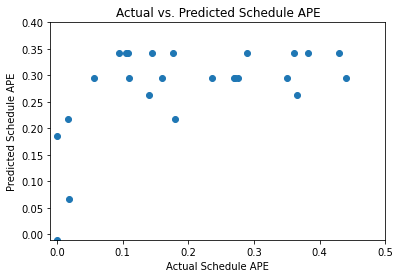

In [0]:
plt.scatter(y_test_schedule, schedule_fitted_model_test_predictions)
plt.xlabel("Actual Schedule APE")
plt.ylabel("Predicted Schedule APE")
plt.title("Actual vs. Predicted Schedule APE")
plt.xlim(-0.01,0.5)
plt.ylim(-0.01,0.4)
plt.show()

In [0]:
# Calculate Train and Test RMSE

print("Baseline Schedule Model Train RMSE:", np.round(mean_squared_error(y_train_schedule, schedule_fitted_model_y_pred_train, squared=True),2))
print("Baseline Schedule Model Test RMSE:", np.round(mean_squared_error(y_test_schedule, schedule_fitted_model_test_predictions, squared=True),2))


Baseline Schedule Model Train RMSE: 0.02
Baseline Schedule Model Test RMSE: 0.03


- Model Diagnostics:

Text(0, 0.5, 'Frequency')

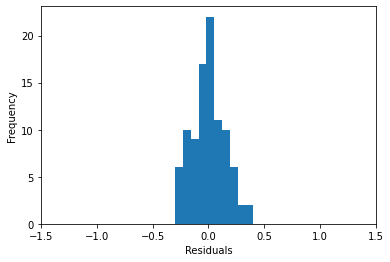

In [0]:
# histogram of residuals
schedule_resid = schedule_fitted_model_baseline.resid
plt.xlim(-1.5,1.5)
plt.hist(schedule_resid)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

The residuals are normally distributed around a mean of zero.

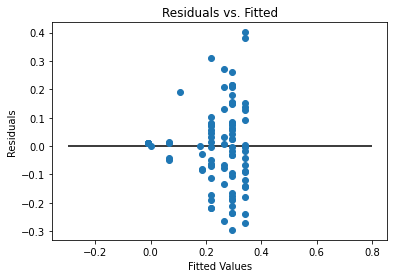

In [0]:
# Create the plot of residuals vs. fitted to look for a pattern
plt.plot(schedule_fitted_model_baseline.fittedvalues, schedule_fitted_model_baseline.resid, 'o')
plt.hlines(xmin=-0.3, xmax=0.8, y=0)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

There is heteroskedasticity in our schedule APE baseline linear regression model.  As we discussed in the budget APE baseline linear regression model, this is not easy to correct with our limited knowledge of the project scopes. 

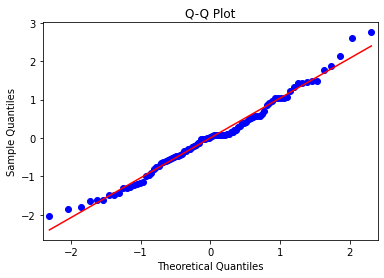

In [0]:
fig = sm.qqplot(schedule_resid, fit=True, line='r')
plt.title('Q-Q Plot')
plt.show()

The qq plot is fairly normal; there are some slight departures from normality at the extreme theoretical quantiles but overall the observations in the model are normally distributed.

# -----------------------------------------------------------------------------------------------------------------

#4 - Visualizing using a Statistical Modeling Approach

- Using Bayesian Priors and Iterative Simulation on NYC Projects Under Construction

  - Iteratively processing the data for each timestep, we can *simulate the completion process* of a project, indicating *what amount of scope is completed at what time*. 
  - We measure simulated "manpower", the number of workers on a site at any time, as a close estimation of the amount of scope being completed.



###Step 1 - Extract Project Priors
- Set "Prior" Distributions and Understanding
  - *Weighting for Project Costs*
  - *Weighting for Project Labor Breakdown*
  - *Labor Costs*
  - *Project Descriptors *
- *Linear Equations for Each*

To visualize the amount of scope completed per date, we **selected a manpower loading "prior" distribution called the "NECA" Curves** (generated by the National Electrical Contractors Association, first published in 1972, and re-published annually).


This curve, showing typical activity per time stamp, and recommended maximum loadings is as follows:

![NECA_loading_curve](https://drive.google.com/uc?id=1TBoobJ-LDteou_usS0CvgVHU3H9NcvV1)



And a corresponding cumulative scope completion curve is:

![NECA_cumulative_completion_curves](https://drive.google.com/uc?id=17dEM-TkZM6glK9GFXKpKt9NtOnSH9JLa)


- Loading Additional Datasets in
  - Labor "prior" - costs (hourly) by project

In [0]:
nyc_labor_path = "labor_rates.csv"
nyc_labor = filepath+nyc_labor_path

nyc_labor_df = pd.read_csv(nyc_labor, encoding= 'unicode_escape')

#labor rates
display(nyc_labor_df)

#name the rates for easy data calling
  #Civil, Bridges and Heavy Projects
civil_equipment_labor = float(nyc_labor_df['civil.2'][3])
civil_skilled_labor = float(nyc_labor_df['civil.1'][3])
civil_unskilled_labor = float(nyc_labor_df['civil'][3])
civil_labor = [civil_equipment_labor,civil_skilled_labor,civil_unskilled_labor]

  #Buildings and Renovations
building_equipment_labor = float(nyc_labor_df['building.2'][3])
building_skilled_labor = float(nyc_labor_df['building.1'][3])
building_unskilled_labor = float(nyc_labor_df['building'][3])
building_labor = [building_equipment_labor,building_skilled_labor,building_unskilled_labor]

  #Streetwork and Sewers
street_equipment_labor = float(nyc_labor_df['street.2'][3])
street_skilled_labor = float(nyc_labor_df['street.1'][3])
street_unskilled_labor = float(nyc_labor_df['street'][3])
street_labor = [street_equipment_labor,street_skilled_labor,street_unskilled_labor]

  #Public Parks and Greenspaces (without structural or major sitework)
park_equipment_labor = float(nyc_labor_df['park.2'][3])
park_skilled_labor = float(nyc_labor_df['park.1'][3])
park_unskilled_labor = float(nyc_labor_df['park'][3])
park_labor = [park_equipment_labor,park_skilled_labor,park_unskilled_labor]

####################
# Construction Category Flags
nyc_con_flags = "Construction_Flags.csv"
nyc_con_flags = filepath+nyc_con_flags
nyc_con_flags_df = pd.read_csv(nyc_con_flags, encoding= 'unicode_escape')
#display(nyc_con_flags_df)

nyc_cp_df['Project_Type'] = nyc_con_flags_df['Project Type']

,Unnamed: 0,civil,civil.1,civil.2,building,building.1,building.2,street,street.1,street.2,park,park.1,park.2
0,NaN,unskilled_labor,skilled_labor,equipment_operators,unskilled_labor,skilled_labor,equipment_operators,unskilled_labor,skilled_labor,equipment_operators,unskilled_labor,skilled_labor,equipment_operators
1,base,47.15,62.66,92.43,44.65,61.82,90.36,42.65,55.658,41.185,42.65,56,41.185
2,benefits,44.48,42.45,28.5,44.48,27.8,28.5,44.48,36.0825,46.7225,44.48,56.54,46.7225
3,total,91.63,105.11,120.93,89.13,89.62,118.86,87.13,91.7405,87.9075,87.13,112.54,87.9075


- Establish "weights" for input to linear equation relating project cost to trade labor costs 

In [0]:
"""
data structure = [ [% soft cost, % labor costs, % material costs, % heavy machinery costs], [% of labor is heavy machinery, % of labor is skilled trade labor, % of labor is unskilled general labor] ]
"""

# These are "weights" for a linear equation relating project cost to labor costs 

#Civil Projects
  #total cost = 15% soft + 37.5% labor + 25% material + 12.5% heavy machinery
  #labor = 10% equipment operators + 55% Skilled Labor + 30% Unskilled Labor
civil_weights = [ [0.15, 0.375, 0.35, 0.125], [0.125, 0.55, 0.325] ]

#Streetwork Projects
  #total cost = 20% soft + 52% labor + 20% material + 8% heavy machinery
  #labor = 10% equipment operators + 35% Skilled Labor + 55% Unskilled Labor
street_weights = [ [0.20, 0.52, 0.20, 0.08], [0.10, 0.35, 0.55] ]

#Building Construction 
  #total cost = 20% soft + 52% labor + 25% material+tools + 3% heavy machinery
  #labor = 5% equipment operators + 65% Skilled Labor + 35% Unskilled Labor
building_weights = [ [0.20, 0.52, 0.25, 0.03], [0.05, 0.65, 0.30] ]

#NYC Parks and Greenspaces
  #total cost = 20% soft + 45% labor + 30% material+tools + 5% heavy machinery
  #labor = 10% equipment operators + 50% Skilled Labor + 40% Unskilled Labor
park_weights = [ [0.20, 0.45, 0.30, 0.05], [0.10, 0.50, 0.40] ]

- Function for Statistical Modeling Estimation of Project Cost and Manpower Breakdowns 

In [0]:
def stat_model_project(total_cost, cost_weights, labor_rates):
  """
  function to simulate total project costs and labor hours, based on project types
  project type is input as a set of weights, and labor rates
  returns EXPECTED total hours for each labor type and EXPECTED costs
  """
  #determine costs based on project type's weights
  soft_costs =  cost_weights[0][0] * total_cost
  labor_costs = cost_weights[0][1] * total_cost
  material_costs = cost_weights[0][2] * total_cost
  heavy_tool_costs = cost_weights[0][3] * total_cost

  #determine project man hours based on project type's labor rates and labor distribution
  equipment_labor_hours = labor_costs * cost_weights[1][0] / labor_rates[0]
  skilled_labor_hours = labor_costs * cost_weights[1][1] / labor_rates[1]
  unskilled_labor_hours = labor_costs * cost_weights[1][2] / labor_rates[2]

  #returns two lists, one of project labor hours, and the other of projected costs
  return [equipment_labor_hours, skilled_labor_hours, unskilled_labor_hours], [soft_costs, labor_costs, material_costs, heavy_tool_costs]

###Step 2 - Set Project Parameters

#### Project Number:
  - Enter a project number that is under construction. Simulation will *not* run for projects in design only (since there is no actual manpower data to sample from)

In [0]:
project_number = 430

if project_number not in unique_projects:
  project_number = 431 #show a default project - Hudson Yards Culture Shead 

#### Hyperparameters:

In [0]:
#multiple of average labor, that is highest allowed peak
allowed_peak_labor = 1.6 #this says "realistically how far above average can I dump on a project before there isn't enough physical space to productively work"

work_hours_per_day = 7 #(paid, but 6.25 productive)
work_days_per_week = 5

#### Fixed Variables:

In [0]:
days_per_week = 7
days_per_month = 30 #assumed (360 days per year for simplicity)
t_step_td = pd.Timedelta('1 days') #time delta for 1 day step

###Step 3 - Set "Prior" Distributions per Project Type

In [0]:
#CODE TO STATISTICALLY MODEL A TYPICAL PROJECT PRIOR DISTRIBUTION
#(PER PRIOR INFORMATION, AND INDUSTRY RESEARCH)

#pull project from the dataset - only those projects rows
nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project_number] #this slice will be used for all iterative passes
project_category = nyc_cp_df_slice['Project_Type'].iloc[0]
project_name = nyc_cp_df_slice['Project_Name'].iloc[0]

In [0]:
#set project Priors
if project_category == 'Street':
  project_weights = street_weights
  project_labor_rates = street_labor
  #print("Street")
elif project_category == 'Building':
  project_weights = building_weights
  project_labor_rates = building_labor
  #print("Bldg")
elif project_category == 'Civil':
  project_weights = civil_weights
  project_labor_rates = civil_labor
  #print("Civil")
else:
  project_weights = park_weights
  project_labor_rates = park_labor
  #print("Else, Park")

## Step 4: Initial Project Simulation


- Function to calculate a construction loading curve (just the trapezoid)
  - does not include or calculate design phase time, this must be added

In [0]:
def calc_loading_curve(construction_start_t, construction_end_t, current_t, current_total_labor_hours, time_section='past', work_hours_per_day=7, estimated_construction_rampup=0, estimated_peak_construction_length=0, estimated_construction_wind_down=0):
  """
  this ONLY computes loading for the construction phase
  time starts at construction_start_t and runs to construction_end_t
  past cutoff is current_t
  it will return total labor hours after current_t, for each day between current_t and construction_end_t
  Bool Flag cut_off_future determines what slice of current_t to return:
  - True, returns construction_start_t  --> current_t
  - False, returns current_t --> construction_end_t
  """
  #generate dataframe of ramp up
  loading_by_day = []
  wind_down_by_day = [] 

  con_phase_length = construction_end_t - construction_start_t
  #print(con_phase_length)
  #print(present_timestamp)
  current_timestamp = current_t - construction_end_t

#################################

  #get phase lengths
  
  if estimated_construction_rampup == 0: #if phase length not given
    construction_rampup = 0.40 * con_phase_length
  else:
    construction_rampup = estimated_construction_rampup

  if estimated_peak_construction_length == 0: #if phase length not given
    peak_construction_length = 0.40 * con_phase_length
  else:
    peak_construction_length = estimated_peak_construction_length

  if estimated_construction_wind_down == 0: #if phase length not given
    construction_wind_down = 0.20 * con_phase_length
  else:
    estimated_construction_wind_down = construction_wind_down

#################################  

  #FIRST GOING TO ESTIMATE THIS SPLINE USING A TRAPEZOID, AND SOLVE LATER FOR NON-LINEARITY
  #h = 2 * A / (B1 + B2)
  current_total_labor_days = (current_total_labor_hours/work_hours_per_day)
  peak_loading = 2 * current_total_labor_days / (con_phase_length + peak_construction_length) #height of the trapezoid approximation

  tangent_rampup = (peak_loading / construction_rampup)
  tangent_rampdn = (peak_loading / construction_wind_down)

  for day in range(0,int(con_phase_length)+1,1): #for length of construction phase

    if day < (construction_rampup):
      #get tangent of loading triangle
      daily_loading = tangent_rampup * day
      loading_by_day.append(daily_loading)

    elif day >= (construction_rampup) and day <= (construction_rampup + peak_construction_length):
      daily_loading = peak_loading
      loading_by_day.append(daily_loading)

    elif day >= (construction_rampup + peak_construction_length) and day <= (con_phase_length):
      daily_loading = tangent_rampdn * (day - (construction_rampup  + peak_construction_length))
      wind_down_by_day.append(daily_loading)

    else:
      #loading_by_day.append('Code Fail!')
      loading_by_day.append(0)

  # for i in range(0,(current_time_t - start_of_con), 1): #this is to create blank space before current_time_t
  #   test_current_load_reformatted.append(0)

  #merge the two loading trapezoids together
  wind_down_by_day.reverse()
  loading_by_day = loading_by_day + wind_down_by_day

  if current_t != 0:
    if time_section == 'past':
      #ditch the future values, show the past
      loading_by_day = loading_by_day[:current_timestamp]
    if time_section == 'future':
    #ditch the past values, show the future
      loading_by_day = loading_by_day[current_timestamp:]

  return loading_by_day

- Function to produce a cumulative labor diagram:
  - will be same for cumulative cost diagram

In [0]:
def calc_cumulative_curve(selected_loading_curve):
  """
  Produce a Cumulative Curve List, Based on a Loading List
  """
  cumulative_curve = []
  for day in range(0,len(selected_loading_curve),1):
    if day == 0:
      cumulative_curve.append(selected_loading_curve[day])
    else:
      cumulative_curve.append(selected_loading_curve[day] + cumulative_curve[day - 1])
  return cumulative_curve

- Function to produce a Percentage Complete Diagram

In [0]:
def calc_percent_complete_from_cumulative_curve(cumul_curve):
  """
  convert a cumulative manpower curve to percentage complete
  """
  percent_complete_curve = []
  for item in range(0,len(cumul_curve),1):
    if cumul_curve[item] == 0:
        percent_complete_curve.append(0)
    else:
        percent_complete_curve.append((cumul_curve[item]/max(cumul_curve))*100)
  return percent_complete_curve

- Function to graph the project budget and schedule history

In [0]:
def print_project_status(pid_number, design_plot=False, construction_plot=True):
  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == pid_number]
  latest_observation_index = nyc_cp_df_slice.shape[0]
  # print(nyc_cp_df_slice)

  plt.figure(figsize=(15,8))
  plt.plot(nyc_cp_df_slice['Date_Reported_As_Of'], nyc_cp_df_slice['Budget_Forecast'])
  if design_plot:
    plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Design_Start'], linestyle='-.', color="purple", label="Start of Design") #Design Start
    plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Forecast_Completion'], linestyle='--', color="green", label="Initial Project Completion") #Initial Projected Completion
    plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.max(),'Forecast_Completion'], linestyle='-.', color="black", label="Latest Project Completion") #Current Projected Completion
  if construction_plot:
    if nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Construction_Start'] !=0:
      plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Construction_Start'], linestyle='-.', color="red", label="Start of Construction") #Construction_Start
      plt.legend(fontsize=14)
  plt.title("Budget Forecast - Project #%s - %s" % (int(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'PID']),nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Project_Name']), fontsize=20)
  plt.xlabel("Time of Budget Update", fontsize=14)
  plt.ylabel("Projected Total Cost (USD)", fontsize=14)
  plt.show()

  plt.figure(figsize=(15,8))
  plt.plot(nyc_cp_df_slice['Date_Reported_As_Of'], nyc_cp_df_slice['Forecast_Completion'])
  if design_plot:
    plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Design_Start'], linestyle='-.', color="purple", label="Start of Design") #Design Start
    plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Forecast_Completion'], linestyle='--', color="green", label="Initial Project Completion") #Initial Projected Completion
    plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.max(),'Forecast_Completion'], linestyle='-.', color="black", label="Latest Project Completion") #Current Projected Completion
  if construction_plot:
    if nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Under_Construction'] !=0:
      plt.axvline(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Construction_Start'], linestyle='-.', color="red", label="Start of Construction") #Construction_Start
      plt.legend(fontsize=14)
  plt.title("Schedule Forecast - Project #%s - %s" % (int(nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'PID']),nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Project_Name']), fontsize=20)
  plt.xlabel("Time of Schedule Update", fontsize=14)
  plt.ylabel("Projected Date of Completion", fontsize=14)
  plt.show()

- Parameters for Initial Simulation Duration - NECA Project Loading Curve (per their 2010 Manual, of the National Association of Electrical Contractors):
  - Per research, loading per duration is not significantly different per project type

In [0]:
#CALCULATE INITIAL PROJECT ASSUMPTIONS

initial_budget = nyc_cp_df_slice['Budget_Forecast'].iloc[0] #initial, first row
initial_project_start = nyc_cp_df_slice['Design_Start'].iloc[0]  #initial, first row
initial_estimated_completion = nyc_cp_df_slice['Forecast_Completion'].iloc[0] #initial, first row
initial_estimated_length_of_project = (initial_estimated_completion - initial_project_start).days

#get project labor and cost information
initial_project_labor_breakout, initial_project_cost_breakout = stat_model_project(initial_budget, project_weights, project_labor_rates)

if nyc_cp_df_slice['Under_Construction'].iloc[0]: #IF project IS under construction, so we can calculate the ACTUAL durations of construction phase
  initial_estimated_construction_phase = (nyc_cp_df_slice['Forecast_Completion'].iloc[0] - nyc_cp_df_slice['Construction_Start'].iloc[0]).days #actual duration
  initial_estimated_design_phase = initial_estimated_length_of_project - initial_estimated_construction_phase #actual duration
  initial_estimated_design_functional_design = (0.30/0.75) * initial_estimated_design_phase
  initial_estimated_design_working_drawings = (0.40/0.75) * initial_estimated_design_phase
  initial_estimated_preconstruction_phase = (0.05/0.75) * initial_estimated_design_phase
  initial_estimated_construction_rampup = 0.40 * initial_estimated_construction_phase
  initial_estimated_peak_construction_length = 0.40 * initial_estimated_construction_phase
  initial_estimated_construction_wind_down = 0.20 * initial_estimated_construction_phase
  print('IS UNDER CONSTRUCTION - using actual dates')

if not nyc_cp_df_slice['Under_Construction'].iloc[0]:  #IF project NOT started, so we can PREDICT  what the durations might be based on standard loading
  initial_estimated_design_phase = (.75/1.75) * initial_estimated_length_of_project #typically 43% of project time
  initial_estimated_design_functional_design = (0.30/0.75) * initial_estimated_design_phase
  initial_estimated_design_working_drawings = (0.40/0.75) * initial_estimated_design_phase
  initial_estimated_preconstruction_phase = (0.05/0.75) * initial_estimated_design_phase
  initial_estimated_construction_phase = (1/1.75) * initial_estimated_length_of_project #typically 57% of project time
  initial_estimated_construction_rampup = 0.40 * initial_estimated_construction_phase
  initial_estimated_peak_construction_length = 0.40 * initial_estimated_construction_phase
  initial_estimated_construction_wind_down = 0.20 * initial_estimated_construction_phase
  print('Is NOT under construction - estimating schedule')
  print('NOTE: FULL PROJECT SIMULATION **CANNOT** BE RUN ON THIS PROJECT!!')
  print('Project must be under construction to sample actual construction progress data.')

#initial phase projections
initial_total_labor_hrs = np.sum(initial_project_labor_breakout)
initial_total_labor_days = initial_total_labor_hrs/work_hours_per_day
initial_peak_loading = max(calc_loading_curve(initial_estimated_design_phase, initial_estimated_length_of_project, 0, initial_total_labor_hrs)) #height of the trapezoid approximation
initial_peak_equipment_operators_per_day = initial_peak_loading * project_weights[1][0]
initial_peak_skilled_per_day = initial_peak_loading * project_weights[1][1]
initial_peak_unskilled_per_day = initial_peak_loading * project_weights[1][2]
initial_estimated_peak_loading = initial_peak_equipment_operators_per_day + initial_peak_skilled_per_day + initial_peak_unskilled_per_day

IS UNDER CONSTRUCTION - using actual dates


- Code to test calc_loading_curve:
  - demonstrating the selection of a current_time_t for calculation

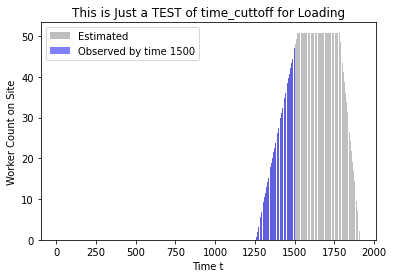

In [0]:
# test this for load curve overlays using creator function

# start_of_project = 0 #time stamp zero
start_of_con = initial_estimated_design_phase
end_of_con = initial_estimated_length_of_project
current_time_t = 1500
total_labor_hrs = initial_total_labor_hrs #area under trapezoid

#empty list of blank design time -- THIS IS A TIME OFFSET FOR START OF CONSTRUCTION
design_time = []
for i in range(0,(start_of_con), 1): #this is to create blank space before current_time_t
  design_time.append(0)

test_initial_load = calc_loading_curve(start_of_con, end_of_con, 0, total_labor_hrs)
test_initial_load = design_time + test_initial_load #add design time
plt.bar(range(0,len(test_initial_load),1), test_initial_load, color="grey", alpha=0.5, label="Estimated")

test_current_load = calc_loading_curve(start_of_con, end_of_con, current_time_t, total_labor_hrs, 'past') #cut off the future values
test_current_load = design_time + test_current_load #add design time
plt.bar(range(0, len(test_current_load), 1), test_current_load, color="blue", alpha=0.5, label="Observed by time %s" % current_time_t)
plt.title("This is Just a TEST of time_cuttoff for Loading")
plt.xlabel("Time t")
plt.ylabel("Worker Count on Site")
plt.legend()
plt.show()

- Function to predict the entire loading curve for a project

In [0]:
def predict_loading_curve(project_category, end_of_project, budget, verbose=False, ape_sched=0, ape_budget=0.0, start_of_construction=0, work_hours_per_day=7, work_days_per_week=5):
  """
  This function takes in assumed values for a new project, and predicts the loading curve for the entire project starting at start_of_design
  All date entries are in ELAPSED DAYS, eg. start_of_design is day '1'
  Function options:
  - If schedule absolute_project_error ape_sched is specified, it will recalculate the curve to be the "over schedule" version
  - If budget absolute_project_error ape_sched is specified, it will recalculate the curve to be the "over budget" version  
  - If a start_of_construction day is entered, then the design time will be fixed to the period from start_of_design to start_of_construction
  - If start_of_construction is NOT entered, or is zero, the design time will be calculated based on standard percentages.

  Example:
  - if the all options are not specified, it will calculate the "initial" loading curve based on industry standard curves.
  - If all the options are specified, it will calculate a "expected" loading curve that best smooths out the anticipated schedule error. 
  """
  #Per research, loading per duration is not significantly different per project type 

#################################

  #adjust cost and duration per APE
  if verbose: #diagnostics
    print("\n--------------------------")
    print("Initial Budgets:")
    print(end_of_project)
    print(budget)

  if float(ape_sched) != 0.0: #if we know the forecsh
    end_of_project = end_of_project * (1+ape_sched)
  if float(ape_budget) != 0.0:  
    budget = budget * (1+ape_budget)
 
  if verbose: #diagnostics
    print("\nAPE Adjusted Budgets:")
    print(end_of_project)
    print(budget)
#################################
 
  #get project phase times

  if start_of_construction != 0: #IF project IS under construction, so we can calculate the ACTUAL durations of construction phase
    estimated_design_phase = start_of_construction #actual duration
    estimated_construction_phase = end_of_project - estimated_design_phase #actual duration
    estimated_design_functional_design = (0.30/0.75) * estimated_design_phase
    estimated_design_working_drawings = (0.40/0.75) * estimated_design_phase
    estimated_preconstruction_phase = (0.05/0.75) * estimated_design_phase
    estimated_construction_rampup = 0.40 * estimated_construction_phase
    estimated_peak_construction_length = 0.40 * estimated_construction_phase
    estimated_construction_wind_down = 0.20 * estimated_construction_phase
    if verbose:
      print('\nIS UNDER CONSTRUCTION - using actual dates')

  if start_of_construction == 0:  #IF project NOT started, so we can PREDICT  what the durations might be based on standard loading
    estimated_design_phase = (.75/1.75) * end_of_project #typically 43% of project time
    estimated_design_functional_design = (0.30/0.75) * estimated_design_phase
    estimated_design_working_drawings = (0.40/0.75) * estimated_design_phase
    estimated_preconstruction_phase = (0.05/0.75) * estimated_design_phase
    estimated_construction_phase = (1/1.75) * end_of_project #typically 57% of project time
    estimated_construction_rampup = 0.40 * estimated_construction_phase
    estimated_peak_construction_length = 0.40 * estimated_construction_phase
    estimated_construction_wind_down = 0.20 * estimated_construction_phase
    if verbose:    
      print('\nIs NOT under construction - estimating schedule')
################################# 

    #set project Priors

  if project_category == 'Street':
    project_weights = street_weights
    project_labor_rates = street_labor
    if verbose:
      print("Street")
  elif project_category == 'Building':
    project_weights = building_weights
    project_labor_rates = building_labor
    if verbose:
      print("Bldg")
  elif project_category == 'Civil':
    project_weights = civil_weights
    project_labor_rates = civil_labor
    if verbose:
      print("Civil")
  else:
    project_weights = park_weights
    project_labor_rates = park_labor
    if verbose:
      print("Else, Park")

#################################

  #get project labor and cost information

  project_labor_breakout, project_cost_breakout = stat_model_project(budget, project_weights, project_labor_rates)

#################################

  #calculate project loading parameters
  total_labor_hrs = np.sum(project_labor_breakout)
  elapsed_start_of_con = estimated_design_phase + 1
  current_day = 0 

  predicted_loading_curve_design = []

  for day in range(1,int(estimated_design_phase),1): #design phase - enter zero values for loading
    predicted_loading_curve_design.append(0)

  predicted_loading_curve_con = calc_loading_curve(elapsed_start_of_con, end_of_project, current_day, total_labor_hrs) #note this function calculates the CONSTRUCTION phase only
  
  #assemble the predicted loading curve
  predicted_loading_curve = predicted_loading_curve_design + predicted_loading_curve_con

  #return the list of labor loading
  if verbose: #diagnostics 
    print(project_labor_breakout)
    print(total_labor_hrs)

  return predicted_loading_curve

## Step 5 - Run Iterative (Time Step) Simulation
- Run sim and generate simulated values for each time step "t" 

- Generate empty Numpy dataframe for the project simulation 

In [0]:
#Generate an empty dataframe for simulating project
project_simulation_df = pd.DataFrame({'PID' : [], 'time_step' : [], 'current_date' : [], 'project_phase' : [], 'current_absolute_forecast_error_budget' : [], 'current_absolute_forecast_error_schedule' : [], 'initial_completion_date' : [], 'current_completion_date' : [], 'remaining_days_until_completion' : [],
                                   'current_days_overschedule' : [], 'initial_total_budget' : [], 'initial_total_soft_costs' : [], 'initial_total_labor_costs' : [], 'initial_total_material_costs' : [], 'initial_total_equipment_costs' : [],
                                   'current_total_budget' : [], 'current_total_soft_costs' : [], 'current_total_labor_costs' : [], 'current_total_material_costs' : [], 'current_total_equipment_costs' : [],
                                   'total_labor_hours' : [], 'total_labor_hours_equipment' : [], 'total_labor_hours_skilled' : [], 'total_labor_hours_unskiilled' : [],
                                   'today_labor_hours_total' : [], 'today_labor_hours_equipment' : [], 'today_labor_hours_skilled' : [], 'today_labor_hours_unskiilled' : [],
                                   'today_labor_workers_total' : [], 'today_labor_workers_equipment' : [], 'today_labor_workers_skilled' : [], 'today_labor_workers_unskiilled' : []})

- **Iterative Simulation** to Create a Dataframe of "Projected Project Data":
  - Iterates though each "update" row of a project, to construct an estimated history. 
  - Recomputes a manpower curve, based on the current known schedule, current known budget, and based on how much money is remaining in project.   
  - Fills a Numpy Dataframe for the "project simulation"

In [0]:
##############################################

#Iterative Simulation

##############################################

#allowed_peak_labor = 1.6 # maximum loading 

verbose = False #print Major Iteration Step Summary?
diagnostics = False #print diagnostics for output of function?

##############################################

#initialize starting values of sim
t = 1 #time step of simulation
# note: these values are actual row numbers, and are used by 'loc' in function (rather than indexes)
first_row = nyc_cp_df_slice.index.min() #initialize with inital starting row 
total_rows  = nyc_cp_df_slice.shape[0]
end_row = first_row + (total_rows - 1)
end_t = nyc_cp_df_slice.loc[end_row, 'Total_Days'] #last known time t of the project

##############################################

for row in range(first_row,end_row+1,1): #for each row of the project data slice
  if diagnostics:
    print("Starting Row %s" % row)
  # check to see when the NEXT ACTUAL update of the project is in the spread sheet “next t”
  if row != end_row: #if not on last row
    t_next_update = nyc_cp_df_slice.loc[(row + 1), 'Elapsed_Days_of_Date_Reported_As_Of'] #how long can the sim run without an update?
  else:
    t_next_update = end_t + 1
  if diagnostics:
    print("Next Update:", t_next_update)

  #schedule, budget and labor updates for this update "row"
  current_budget = nyc_cp_df_slice.loc[row, 'Budget_Forecast']
  current_project_labor_breakout, current_project_cost_breakout = stat_model_project(current_budget,project_weights,project_labor_rates)
  current_total_labor_hours = np.sum(current_project_labor_breakout)

  if row == first_row:
    remaining_labor_hours =  current_total_labor_hours
  else:
    remaining_labor_hours = (current_total_labor_hours - project_simulation_df.loc[(project_simulation_df.index.max()-1), 'total_labor_hours'])

  #record current forecasted completion date
  current_total_schedule_days = nyc_cp_df_slice.loc[row, 'Total_Days'] 
  current_total_design_days = nyc_cp_df_slice.loc[row, 'Total_Design_Days']
  current_total_construction_days = nyc_cp_df_slice.loc[row, 'Total_Construction_Days']
  forecasted_completion = nyc_cp_df_slice.loc[row, 'Forecast_Completion']
  
  #check edge condition where the next schedule update is posted AFTER the previous end date has ALREADY past
  if row != end_row: #if not on last row
    current_row_end_time = t_next_update
    if current_row_end_time > current_total_schedule_days: #if the current row ends after the total schedule ends
      forecasted_completion = nyc_cp_df_slice.loc[(row + 1), 'Forecast_Completion'] #make sure the Forecast_completion is the next rows
      current_total_schedule_days = nyc_cp_df_slice.loc[(row + 1), 'Total_Days']  
      current_total_design_days = nyc_cp_df_slice.loc[(row + 1), 'Total_Design_Days']
      current_total_construction_days = nyc_cp_df_slice.loc[(row + 1), 'Total_Construction_Days']

  ape_b = calc_ape(initial_budget, current_budget) #calculate current APE - Budget
  ape_s = calc_ape(initial_estimated_length_of_project, current_total_schedule_days) #calculate current APE - Schedule

  ##############################################

  #get logic of schedule updates (for ease of diagnostics)
  if row != end_row: #if not on last row :
    if nyc_cp_df_slice.loc[row + 1, 'Forecast_Completion'] == nyc_cp_df_slice.loc[row, 'Forecast_Completion']: #if theres no schedule change
      schedule_change = False
    else:
      schedule_change = True #if there IS a schedule change
  else:
      schedule_change = False
  if row != end_row: #if not on last row :
    if nyc_cp_df_slice.loc[row + 1, 'Budget_Forecast'] == nyc_cp_df_slice.loc[row, 'Budget_Forecast']: #if theres no schedule change
      budget_change = False
    else:
      budget_change = True #if there IS a schedule change
  else:
    budget_change = False

  if schedule_change and not budget_change: #have to recalculate trapezoid length
    pass
  elif budget_change and not schedule_change: #have to recalculate trapezoid height, and recalculate length based on assumed maximum height 
    pass
  elif budget_change and schedule_change: #have to recalculate trapezoid to fit height and length
    pass
  else: #can keep going with the existing trapezoid from before
    pass

  ##############################################

  #calculate the current part of the loading triangle
  
  con_start_index_t = int(current_total_schedule_days) - int(current_total_construction_days) #day count where construction starts
  #current_loading_curve = calc_loading_curve((construction_start_t, construction_end_t, current_t (cutoff threshold, discard time that comes beforehand), current_labor_hours, work_hours_per_day)

  current_loading_curve = calc_loading_curve(con_start_index_t, int(current_total_schedule_days), int(t), int(current_total_labor_hours), 'future') #returns the future values after t

  if verbose:
    print("Current Start t:", t)
    print("Loading curve:", current_loading_curve)
    print("Current End t:", t_next_update)

  ##############################################
  #run through each day of the sim, till the next update
  for day in range(int(t), int(t_next_update), 1): #for time between udpates

    #iterative count, indexed from zero for list
    if int(day) == int(t_next_update):
      i = (int(day))
    else:
      i = int(day) - int(t)
    if diagnostics:
      print(i)

    #record the date
    if day == 1:
      current_date = nyc_cp_df_slice.loc[row, 'Design_Start']
    else:
      current_date = project_simulation_df.loc[day - 1, 'current_date'] + t_step_td 
    
    #record the phase
    if day < nyc_cp_df_slice.loc[row, 'Total_Design_Days']:
      if day < initial_estimated_design_functional_design:
        project_phase = "Design - Functional Design"
      elif day < (initial_estimated_design_functional_design + initial_estimated_design_working_drawings):
        project_phase = "Design - Working Drawings"
      elif day < (initial_estimated_design_functional_design + initial_estimated_design_working_drawings + initial_estimated_preconstruction_phase):
        project_phase = "Construction Procurement"
    if day > nyc_cp_df_slice.loc[row, 'Total_Design_Days']:
          project_phase = "Construction"

    #compute days overschedule
    if current_date > initial_estimated_completion:
      days_overschedule = current_date - initial_estimated_completion
    else:
      days_overschedule = 0

    #calculate loading info
    if day >= con_start_index_t and day < current_total_schedule_days:
      today_labor_hours_total = current_loading_curve[i] #hours on the curve for today, from the simulation of this "row time section"
      today_labor_hours_equipment = today_labor_hours_total * project_weights[1][0]
      today_labor_hours_skilled = today_labor_hours_total * project_weights[1][1]
      today_labor_hours_unskiilled = today_labor_hours_total * project_weights[1][2]

      today_labor_workers_total = today_labor_hours_total / work_hours_per_day
      today_labor_workers_equipment = today_labor_hours_equipment / work_hours_per_day
      today_labor_workers_skilled = today_labor_hours_skilled / work_hours_per_day
      today_labor_workers_unskiilled = today_labor_hours_unskiilled / work_hours_per_day
    else:
      today_labor_hours_total = 0
      today_labor_hours_equipment = 0
      today_labor_hours_skilled = 0
      today_labor_hours_unskiilled = 0

      today_labor_workers_total = 0
      today_labor_workers_equipment = 0
      today_labor_workers_skilled = 0
      today_labor_workers_unskiilled = 0

    ##############################################

    #record this day to the simulation dataframe   
    project_simulation_df.loc[day, 'PID'] = int(project_number)
    project_simulation_df.loc[day, 'time_step'] = int(day)
    project_simulation_df.loc[day, 'current_date'] = current_date
    project_simulation_df.loc[day, 'project_phase'] = project_phase
    
    project_simulation_df.loc[day, 'current_absolute_forecast_error_budget'] = ape_b  
    project_simulation_df.loc[day, 'current_absolute_forecast_error_schedule'] = ape_s 

    project_simulation_df.loc[day, 'initial_completion_date'] = initial_estimated_completion
    project_simulation_df.loc[day, 'current_completion_date'] = forecasted_completion
    project_simulation_df.loc[day, 'remaining_days_until_completion'] = (forecasted_completion - current_date).days
    project_simulation_df.loc[day, 'current_days_overschedule'] = days_overschedule

    project_simulation_df.loc[day, 'initial_total_budget'] = initial_budget
    project_simulation_df.loc[day, 'initial_total_soft_costs'] = initial_project_cost_breakout[0]
    project_simulation_df.loc[day, 'initial_total_labor_costs'] = initial_project_cost_breakout[1]
    project_simulation_df.loc[day, 'initial_total_material_costs'] = initial_project_cost_breakout[2]
    project_simulation_df.loc[day, 'initial_total_equipment_costs'] = initial_project_cost_breakout[3]

    project_simulation_df.loc[day, 'current_total_budget'] = current_budget
    project_simulation_df.loc[day, 'current_total_soft_costs'] = current_project_cost_breakout[0]
    project_simulation_df.loc[day, 'current_total_labor_costs'] = current_project_cost_breakout[1]
    project_simulation_df.loc[day, 'current_total_material_costs'] = current_project_cost_breakout[2]
    project_simulation_df.loc[day, 'current_total_equipment_costs'] = current_project_cost_breakout[3]

    project_simulation_df.loc[day, 'total_labor_hours'] = current_total_labor_hours
    project_simulation_df.loc[day, 'total_labor_hours_equipment'] = current_project_labor_breakout[0]
    project_simulation_df.loc[day, 'total_labor_hours_skilled'] = current_project_labor_breakout[1]
    project_simulation_df.loc[day, 'total_labor_hours_unskiilled'] = current_project_labor_breakout[2] 

    project_simulation_df.loc[day, 'today_labor_hours_total'] = today_labor_hours_total
    project_simulation_df.loc[day, 'today_labor_hours_equipment'] = today_labor_hours_equipment
    project_simulation_df.loc[day, 'today_labor_hours_skilled'] = today_labor_hours_skilled
    project_simulation_df.loc[day, 'today_labor_hours_unskiilled'] = today_labor_workers_unskiilled

    project_simulation_df.loc[day, 'today_labor_workers_total'] = today_labor_workers_total 
    project_simulation_df.loc[day, 'today_labor_workers_equipment'] = today_labor_workers_equipment
    project_simulation_df.loc[day, 'today_labor_workers_skilled'] = today_labor_workers_skilled
    project_simulation_df.loc[day, 'today_labor_workers_unskiilled'] = today_labor_workers_unskiilled

    # recommended_peak = allowed_peak_labor * average_labor

    if diagnostics:
      print("      day ", day)
  ##############################################

  t = t_next_update #update the time step to next "official update"
  if verbose:
    print("---------------------------------------------------")
  ##############################################

- Results of Iterative Statistical Modeling:

In [0]:
display(project_simulation_df.head(3))

,PID,time_step,current_date,project_phase,current_absolute_forecast_error_budget,current_absolute_forecast_error_schedule,initial_completion_date,current_completion_date,remaining_days_until_completion,current_days_overschedule,initial_total_budget,initial_total_soft_costs,initial_total_labor_costs,initial_total_material_costs,initial_total_equipment_costs,current_total_budget,current_total_soft_costs,current_total_labor_costs,current_total_material_costs,current_total_equipment_costs,total_labor_hours,total_labor_hours_equipment,total_labor_hours_skilled,total_labor_hours_unskiilled,today_labor_hours_total,today_labor_hours_equipment,today_labor_hours_skilled,today_labor_hours_unskiilled,today_labor_workers_total,today_labor_workers_equipment,today_labor_workers_skilled,today_labor_workers_unskiilled
1,430.0,1.0,2011-08-24 00:00:00,Design - Functional Design,0.0,0.0,2016-11-19 00:00:00,2016-11-19 00:00:00,1914.0,0,27925000.0,5585000.0,14521000.0,5585000.0,2234000.0,27925000.0,5585000.0,14521000.0,5585000.0,2234000.0,163580.154602,16518.499559,55399.196647,91662.458396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,430.0,2.0,2011-08-25 00:00:00,Design - Functional Design,0.0,0.0,2016-11-19 00:00:00,2016-11-19 00:00:00,1913.0,0,27925000.0,5585000.0,14521000.0,5585000.0,2234000.0,27925000.0,5585000.0,14521000.0,5585000.0,2234000.0,163580.154602,16518.499559,55399.196647,91662.458396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,430.0,3.0,2011-08-26 00:00:00,Design - Functional Design,0.0,0.0,2016-11-19 00:00:00,2016-11-19 00:00:00,1912.0,0,27925000.0,5585000.0,14521000.0,5585000.0,2234000.0,27925000.0,5585000.0,14521000.0,5585000.0,2234000.0,163580.154602,16518.499559,55399.196647,91662.458396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 6 - Visualizing Project Simulations

- Process simulated data to Prepare Visualzations:

In [0]:
##############################################

#COMPILE KEY PROJECT STATS

##############################################

#row indexes of slices for .loc
first_row = nyc_cp_df_slice.index.min() #initialize with inital starting row
last_row = first_row + (nyc_cp_df_slice.shape[0] - 1)

initial_forecast_end_of_project = nyc_cp_df_slice.loc[first_row, 'Total_Days']
schedule_overrun = nyc_cp_df_slice.loc[last_row, 'Total_Schedule_Changes']
initial_forecast_budget = nyc_cp_df_slice.loc[first_row, 'Budget_Forecast']
budget_overun = nyc_cp_df_slice.loc[last_row, 'Total_Budget_Changes']

##############################################

con_start = nyc_cp_df_slice.loc[last_row, 'Total_Design_Days'] + 1 #because construction starts at end of design

##############################################

#calculate APE
actual_ape_sched = calc_ape(initial_forecast_end_of_project, (initial_forecast_end_of_project + schedule_overrun)) #(initial value, new value)
actual_ape_budget = calc_ape(initial_forecast_budget, (initial_forecast_budget + budget_overun)) #(initial value, new value)

##############################################

#Test values, simulating
predicted_ape_sched = schedule_fitted_model_test_predictions.loc[project_number]  
predicted_ape_budget = budget_fitted_model_test_predictions.loc[project_number] 

##############################################

initial_ape_load = predict_loading_curve(project_category, initial_forecast_end_of_project, initial_forecast_budget, False) #initial project projection
predicted_ape_load = predict_loading_curve(project_category, initial_forecast_end_of_project, initial_forecast_budget, False, predicted_ape_sched, predicted_ape_budget, con_start) #initial project projection corrected for APE, KNOWING the start of construction
expected_ape_load = predict_loading_curve(project_category, initial_forecast_end_of_project, initial_forecast_budget, False, actual_ape_sched, actual_ape_budget, con_start) #initial project projection corrected for APE, KNOWING the start of construction

##############################################

maximum_sim_length = max( len(initial_ape_load),len(expected_ape_load), len(predicted_ape_load) ) #whats the latest forecasted completion time?
maximum_peak_height = max ( max(initial_ape_load), max(expected_ape_load), max(predicted_ape_load), max(project_simulation_df.today_labor_hours_total) )

##############################################

#calculate manpower means

initial_ape_load_mean = []
for item in range(0,len(initial_ape_load)):
  if initial_ape_load[item] != 0:
    initial_ape_load_mean.append(initial_ape_load[item])
initial_ape_load_mean = mean(initial_ape_load_mean) 

expected_ape_load_mean = []
for item in range(0,len(expected_ape_load)):
  if expected_ape_load[item] != 0:
    expected_ape_load_mean.append(expected_ape_load[item])
expected_ape_load_mean = mean(expected_ape_load_mean)

initial_ape_load_max = max(initial_ape_load)
expected_ape_load_max = max(expected_ape_load)
initial_recommended_max = initial_ape_load_mean * allowed_peak_labor #1.6x

##############################################


- Display Project Summaries:

In [0]:
print("##### PROJECT LABOR ESTIMATES #####")
print("\nInitial AuC:      %.0f Total Man Days" % sum(initial_ape_load))
print("Predicted AuC:    %.0f Total Man Days" % sum(predicted_ape_load))
print("Actual AuC:       %.0f Total Man Days" % sum(project_simulation_df.today_labor_hours_total))
print("Recommended AuC:  %.0f Total Man Days" % sum(expected_ape_load))

##### PROJECT LABOR ESTIMATES #####

Initial AuC:      23372 Total Man Days
Predicted AuC:    34682 Total Man Days
Actual AuC:       44424 Total Man Days
Recommended AuC:  28226 Total Man Days


In [0]:
##############################################

#PRINT PROJECT SUMMARY
print("######  INITIAL PROJECT PROJECTION  ###### ")

print("Project #%s" % project_number)
print("Project Name: '%s'" % project_name)
print("Project Category is '%s'" % project_category)
print("\nProject Budget:")
print("Initial Budget was $%.2f" % initial_budget)
print("Soft Costs -       $%.2f" % initial_project_cost_breakout[0])
print("Labor Costs -      $%.2f" % initial_project_cost_breakout[1])
print("Material Costs -   $%.2f" % initial_project_cost_breakout[2])
print("Equipment Costs -  $%.2f" % initial_project_cost_breakout[3])

print("\nProject Labor:")
print("Equipment Labor -      %.0f Man Days (%.2f Hrs)" % ( (initial_project_labor_breakout[0]/work_hours_per_day), initial_project_labor_breakout[0]) )
print("Skilled Labor -        %.0f Man Days (%.2f Hrs)" % ( (initial_project_labor_breakout[1]/work_hours_per_day), initial_project_labor_breakout[1]) )
print("Unskilled Labor -      %.0f Man Days (%.2f Hrs)" % ( (initial_project_labor_breakout[2]/work_hours_per_day), initial_project_labor_breakout[2]) )
print("Total Labor -          %.0f Man Days (%.2f Hrs)" % ( (initial_total_labor_hrs/work_hours_per_day), initial_total_labor_hrs) )

print("\nProject Schedule:")
print("Estimated Length -     %.0f Days" % initial_estimated_length_of_project)

print("\nEstimated Schedule Summary:")
print("Design Phase -            %.0f Days" % (initial_estimated_design_phase - initial_estimated_preconstruction_phase))
print("Pre-Construction Phase -  %.0f Days" % initial_estimated_preconstruction_phase )
print("Construction Phase -      %.0f Days" % initial_estimated_construction_phase)

print("\nDesign Phase:")
print("Functional Design -       %.0f Days" % initial_estimated_design_functional_design)
print("Working Drawings -        %.0f Days" % initial_estimated_design_working_drawings)

print("\nPre-Construction Phase:")
print("Bidding and Award -       %.0f Days" % initial_estimated_preconstruction_phase )

print("\nConstruction Phase:")
print("Project Ramp Up -         %.0f Days" % initial_estimated_construction_rampup)
print("Labor Peak -              %.0f Days" % initial_estimated_peak_construction_length)
print("Wind-down & Close Out  -  %.0f Days" % initial_estimated_construction_wind_down)

print("\n\nProject Loading:")
print("\nTotal Workers -        %.0f Workers per Day Average" % initial_ape_load_mean)
print("Equipment Operators -  %.0f Workers per Day Average" % (initial_ape_load_mean*project_weights[1][0]))
print("Skilled Tradesmen -    %.0f Workers per Day Average" % (initial_ape_load_mean*project_weights[1][1]))
print("Unskilled Laborers -   %.0f Workers per Day Average" % (initial_ape_load_mean*project_weights[1][2]))

print("\nPeak Loading   -       %.0f Total Workers" % initial_ape_load_max)
print("                       %.0f Equipment Operators" % (initial_ape_load_max*project_weights[1][0]))
print("                       %.0f Skilled Tradesmen" % (initial_ape_load_max*project_weights[1][1]))
print("                       %.0f Unskilled Laborers\n\n" % (initial_ape_load_max*project_weights[1][2]))

##############################################

######  INITIAL PROJECT PROJECTION  ###### 
Project #430
Project Name: 'Gansevoort Area Roadway Reconstruction'
Project Category is 'Street'

Project Budget:
Initial Budget was $27925000.00
Soft Costs -       $5585000.00
Labor Costs -      $14521000.00
Material Costs -   $5585000.00
Equipment Costs -  $2234000.00

Project Labor:
Equipment Labor -      2360 Man Days (16518.50 Hrs)
Skilled Labor -        7914 Man Days (55399.20 Hrs)
Unskilled Labor -      13095 Man Days (91662.46 Hrs)
Total Labor -          23369 Man Days (163580.15 Hrs)

Project Schedule:
Estimated Length -     1914 Days

Estimated Schedule Summary:
Design Phase -            1173 Days
Pre-Construction Phase -  84 Days
Construction Phase -      657 Days

Design Phase:
Functional Design -       503 Days
Working Drawings -        670 Days

Pre-Construction Phase:
Bidding and Award -       84 Days

Construction Phase:
Project Ramp Up -         263 Days
Labor Peak -              263 Days
Wind-down & Close Out  -  131 Days




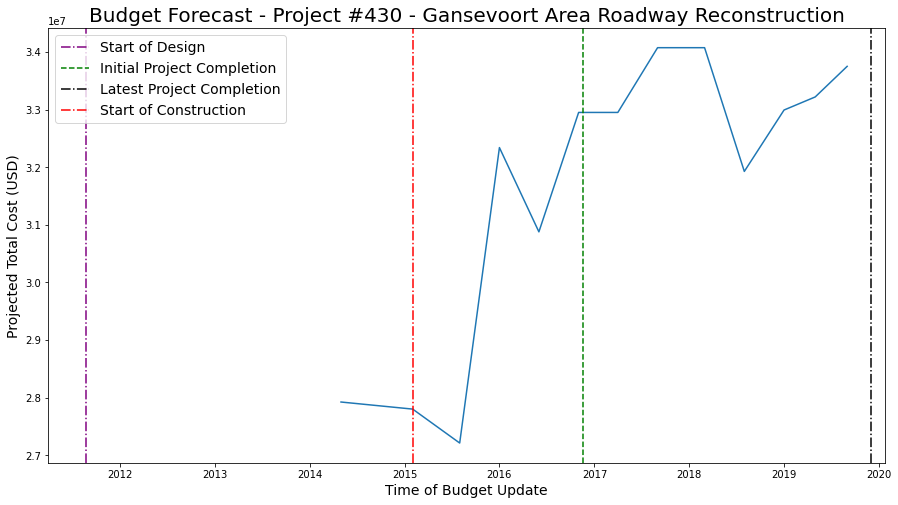

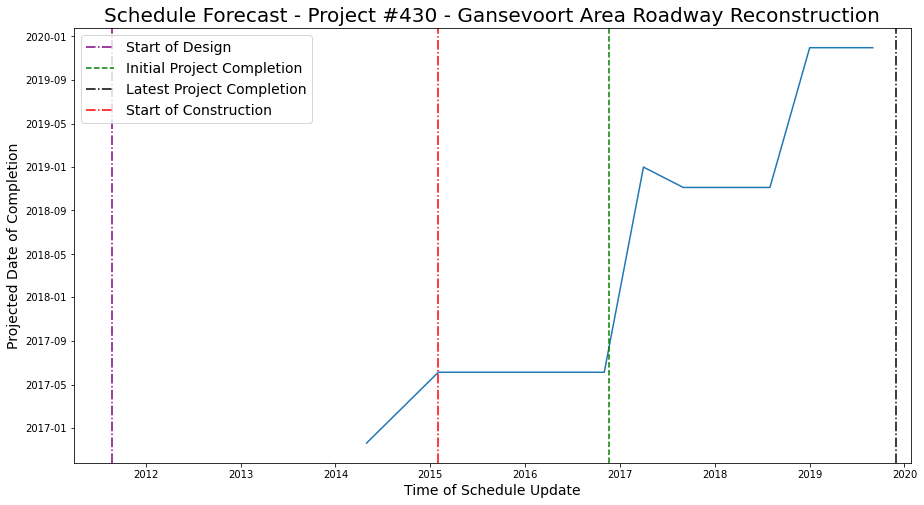

In [0]:
##############################################
#show Summary for budget and schedule updates
print_project_status(project_number, True, True)
##############################################

- Plot an Empty Timeline to assist in Visualizing/Presentation
  - Key dates based on elapsed project time

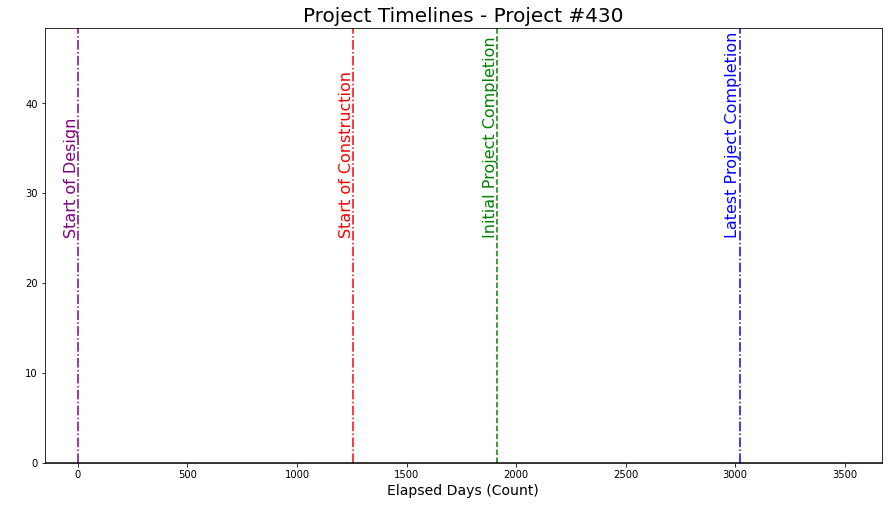

In [0]:
##############################################

#EMPTY CHART OF CONSTRUCTION TIMES

plt.figure(figsize=(15,8))

plt.title("Project Timelines - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)

plt.ylabel(" ", fontsize=14)

x_padding = maximum_sim_length*0.05
y_padding = maximum_peak_height*0.05
plt.xlim(-x_padding, (maximum_sim_length + x_padding+500))
plt.ylim(0, (maximum_peak_height + y_padding))

plot_start_of_design = 0
plot_start_of_construction = nyc_cp_df_slice.loc[nyc_cp_df_slice.index.max(),'Total_Design_Days']
plot_initial_completion = nyc_cp_df_slice.loc[nyc_cp_df_slice.index.min(),'Total_Days']
plot_actual_completion = nyc_cp_df_slice.loc[nyc_cp_df_slice.index.max(),'Total_Days']

text_ht_offset = 0.55

plt.text(plot_start_of_design - 65, maximum_peak_height*text_ht_offset, "Start of Design", color="purple", fontsize=16, rotation=90)
plt.axvline(0, linestyle='-.', color="purple", label="Start of Design") #Design Start
plt.text(plot_start_of_construction - 65, maximum_peak_height*text_ht_offset, "Start of Construction", color="red", fontsize=16, rotation=90)
plt.axvline(plot_start_of_construction, linestyle='-.', color="red", label="Start of Construction") #Construction_Start
plt.text(plot_initial_completion - 65, maximum_peak_height*text_ht_offset, "Initial Project Completion", color="green", fontsize=16, rotation=90)
plt.axvline(plot_initial_completion, linestyle='--', color="green", label="Initial Project Completion") #Initial Projected Completion
plt.text(plot_actual_completion - 65, maximum_peak_height*text_ht_offset, "Latest Project Completion", color="blue", fontsize=16, rotation=90)
plt.axvline(plot_actual_completion, linestyle='-.', color="blue", label="Latest Project Completion") #Current Projected Completion
plt.axhline(0, color="black") #Zero Line

plt.show()
plt.close()
##############################################

- **Visualize Project Loading Forecasts:**
  - *Grey* - Initial Estimates Based on Project Type and Industry Priors
 - *Orange* - Predicted Estimate, produced by linear model, Corrected for Predicted Absolute Forecast and Schedule Errors
 - *Red* - Sampled Actual Data, Forecasting Required loading for the schedule and budget known at each timestep
    - Note: Since scope changes are *not* known, manpower (i.e. budget) is allowed to increase in a circumstance where the simulation could not compute a proper loading distribution. 
  - *Blue* - Expected Estimate, Corrected for Actual Absolute Forecast and Schedule Errors



Initial Project Estimate:
Total Project Days: 1912 Days 
Average Daily Loading: 21 Workers
Maximum Daily Loading: 31 Workers

Recommended Project Estimate:
Total Project Days: 3018 Days 
Average Daily Loading: 16 Workers
Maximum Daily Loading: 23 Workers


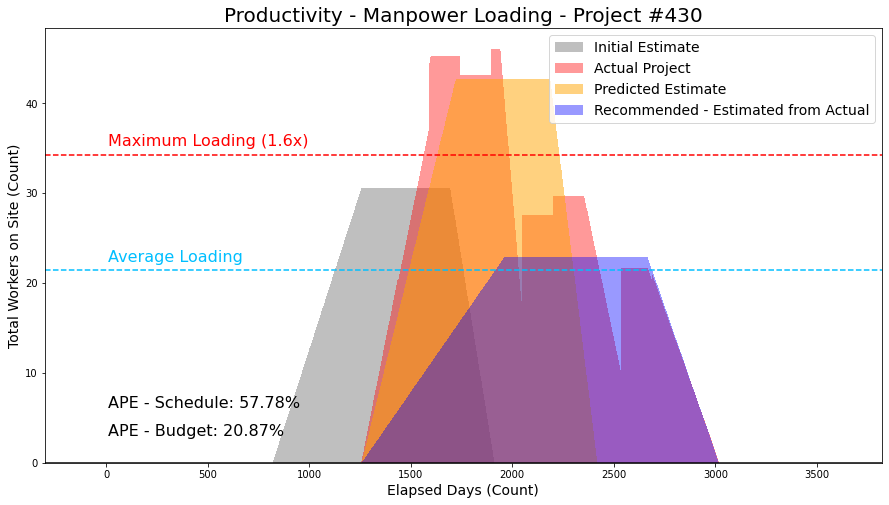

In [0]:
##############################################

# VISUALIZATIONS FOR PRODUCTIVITY AND LABOR PER PROJECT

##############################################

print("\nInitial Project Estimate:")
print("Total Project Days: %s Days " % len(initial_ape_load))
print("Average Daily Loading: %.0f Workers" % initial_ape_load_mean)
print("Maximum Daily Loading: %.0f Workers" % initial_ape_load_max)

print("\nRecommended Project Estimate:")
print("Total Project Days: %s Days " % len(expected_ape_load))
print("Average Daily Loading: %.0f Workers" % expected_ape_load_mean)
print("Maximum Daily Loading: %.0f Workers" % expected_ape_load_max)

##############################################

plt.figure(figsize=(15,8))
plt.bar(range(1,len(initial_ape_load)+1,1), initial_ape_load, color="grey", width=1, alpha=0.5, label="Initial Estimate")
plt.bar(range(1,len(project_simulation_df)+1,1), (project_simulation_df.today_labor_hours_total), width=1, alpha=0.4, color="red", label="Actual Project")
plt.bar(range(1,len(predicted_ape_load)+1,1), predicted_ape_load, color="orange", width=1, alpha=0.5, label="Predicted Estimate")
plt.bar(range(1,len(expected_ape_load)+1,1), expected_ape_load, color="blue", width=1, alpha=0.4, label="Recommended - Estimated from Actual")

plt.title("Productivity - Manpower Loading - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)
plt.ylabel("Total Workers on Site (Count)", fontsize=14)

x_padding = maximum_sim_length*0.10
y_padding = maximum_peak_height*0.05
plt.xlim(-x_padding, (maximum_sim_length + x_padding+500))
plt.ylim(0, (maximum_peak_height + y_padding))

plt.axhline(0, color="black") #Zero Line
plt.axhline(initial_recommended_max, linestyle="--", color="red") #Overloading Line
plt.axhline(initial_ape_load_mean, linestyle="--", color="deepskyblue") #Average Labor Line
plt.text(10, initial_recommended_max+1, "Maximum Loading (1.6x)", color="red", fontsize=16)
plt.text(10, initial_ape_load_mean+1, "Average Loading", color="deepskyblue", fontsize=16)

x_pos = 10
y_pos_up = max(initial_ape_load) - (max(initial_ape_load)*.80)
plt.text(x_pos, y_pos_up, "APE - Schedule: %.2f%%" % (actual_ape_sched*100), fontsize=16)
y_pos_low = y_pos_up - (max(initial_ape_load) * 0.10)
plt.text(x_pos, y_pos_low, "APE - Budget: %.2f%%" % (actual_ape_budget*100), fontsize=16)

plt.legend(fontsize=14, loc='upper right')
#plt.legend(fontsize=14, loc='upper left')
plt.show()
##############################################

- Plot Project Cumulative Forecasts:
  - *Grey* - Initial Estimates Based on Project Type and Industry Priors
 - *Orange* - Predicted Estimate, produced by linear model, Corrected for Predicted Absolute Forecast and Schedule Errors
 - *Red* - Actual sampled productivity data, per schedule and budget known at each timestep (row update in the dataset)
  - *Blue* - Expected Estimate, Corrected for Actual Absolute Forecast and Schedule Errors

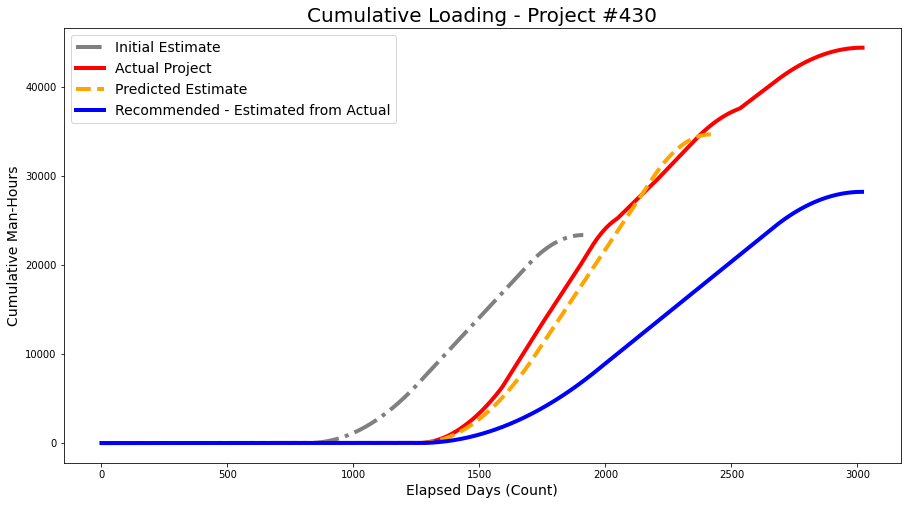

In [0]:
cumulative_manpower_curve_initial = calc_cumulative_curve(initial_ape_load) #initial projection before project has started
cumulative_manpower_curve_predicted = calc_cumulative_curve(predicted_ape_load) #predicted estimates using linear model for APE
cumulative_manpower_curve_actual = calc_cumulative_curve(project_simulation_df['today_labor_hours_total'].to_list()) #actual project data cumulative manpower curves
cumulative_manpower_curve_estimated = calc_cumulative_curve(expected_ape_load) #estimated curves using actual data, for smoother loading - this is the best course of action

plt.figure(figsize=(15,8))
plt.plot(range(1,len(cumulative_manpower_curve_initial)+1,1), cumulative_manpower_curve_initial, "-.", color="grey", linewidth=4.0, label="Initial Estimate")
plt.plot(range(1,len(cumulative_manpower_curve_actual)+1,1), cumulative_manpower_curve_actual, color="red", linewidth=4.0, label="Actual Project")
plt.plot(range(1,len(cumulative_manpower_curve_predicted)+1,1), cumulative_manpower_curve_predicted, "--", color="orange", linewidth=4.0, label="Predicted Estimate")
plt.plot(range(1,len(cumulative_manpower_curve_estimated)+1,1), cumulative_manpower_curve_estimated, color="blue", linewidth=4.0, label="Recommended - Estimated from Actual")

plt.title("Cumulative Loading - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)
plt.ylabel("Cumulative Man-Hours", fontsize=14)
plt.legend(fontsize=14)
plt.show()

- Code to plot Projected Percentage of Completion:
  - *Grey* - Initial Estimates Based on Project Type and Industry Priors
  - *Orange* - Predicted Estimate, produced by linear model, Corrected for Predicted Absolute Forecast and Schedule Errors
  - *Red* - Actual sampled productivity data, per schedule and budget known at each timestep (row update in the dataset)
  - *Blue* - Expected Estimate, Corrected for Actual Absolute Forecast and Schedule Errors

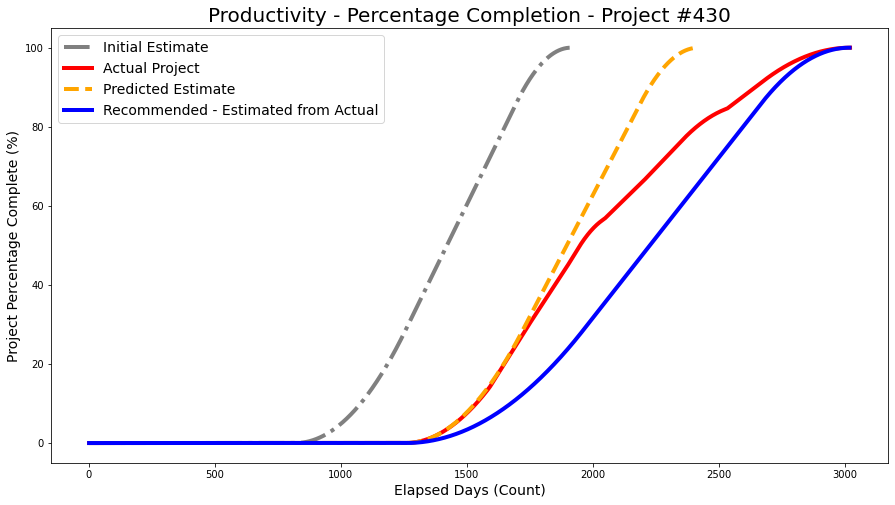

In [0]:
plt.figure(figsize=(15,8))
plt.plot(range(1,len(cumulative_manpower_curve_initial)+1,1), calc_percent_complete_from_cumulative_curve(cumulative_manpower_curve_initial), "-.", color="grey", linewidth=4.0, label="Initial Estimate")
plt.plot(range(1,len(cumulative_manpower_curve_actual)+1,1), calc_percent_complete_from_cumulative_curve(cumulative_manpower_curve_actual), color="red", linewidth=4.0, label="Actual Project")
plt.plot(range(1,len(cumulative_manpower_curve_predicted)+1,1), calc_percent_complete_from_cumulative_curve(cumulative_manpower_curve_predicted), "--", color="orange", linewidth=4.0, label="Predicted Estimate")
plt.plot(range(1,len(cumulative_manpower_curve_estimated)+1,1), calc_percent_complete_from_cumulative_curve(cumulative_manpower_curve_estimated), color="blue", linewidth=4.0, label="Recommended - Estimated from Actual")

plt.title("Productivity - Percentage Completion - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)
plt.ylabel("Project Percentage Complete (%)", fontsize=14)
plt.legend(fontsize=14)
plt.show()

- **Generate ANIMATIONS of a project loading:**
  - By Default, code will display four diagnostics plots of project loading.
  - If show_animation is set to 'True', code will animate through the dataset, one slide for each quarter (three months) month of project (jumps of 90 days).
  - for a given time "t" it will display:
    - *grey* predicted curve first
    - *red* actual curve to time "t"
    - *orange* predicted curve after time T till estimated completion
    - finally, show the *blue* "recommended actual" curve based on the known final budget and final completion date.

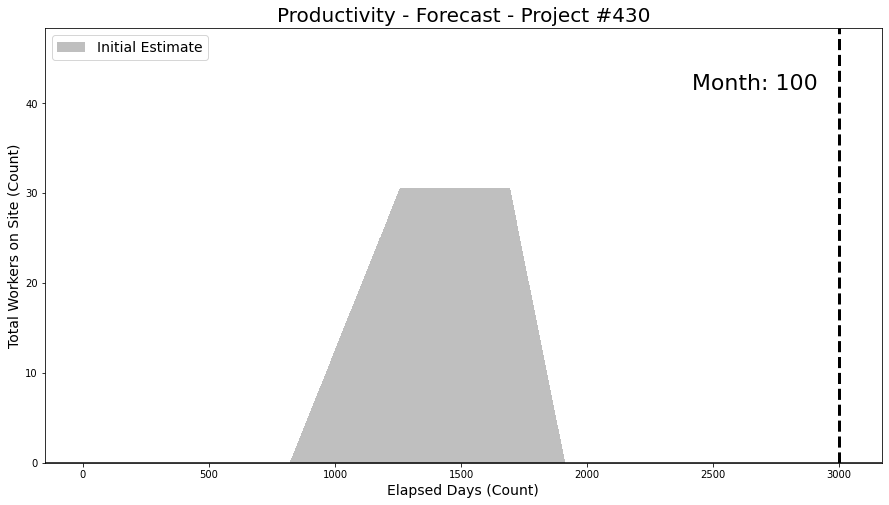

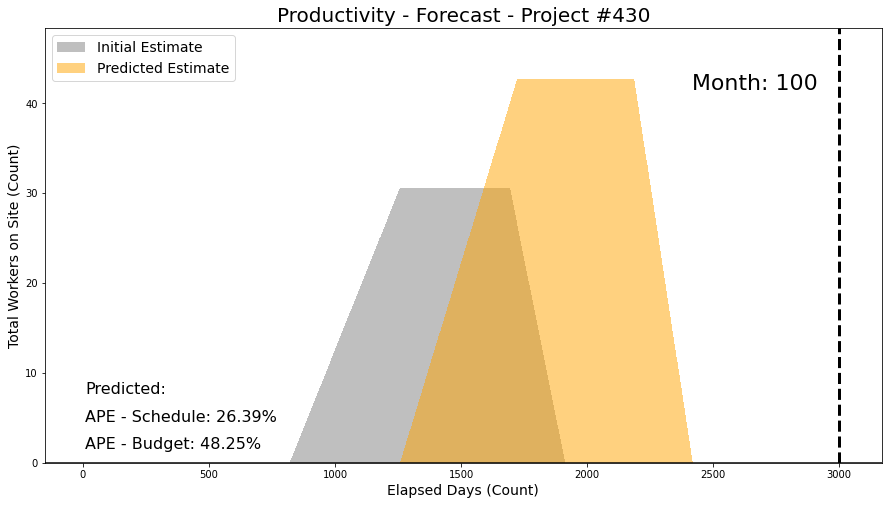

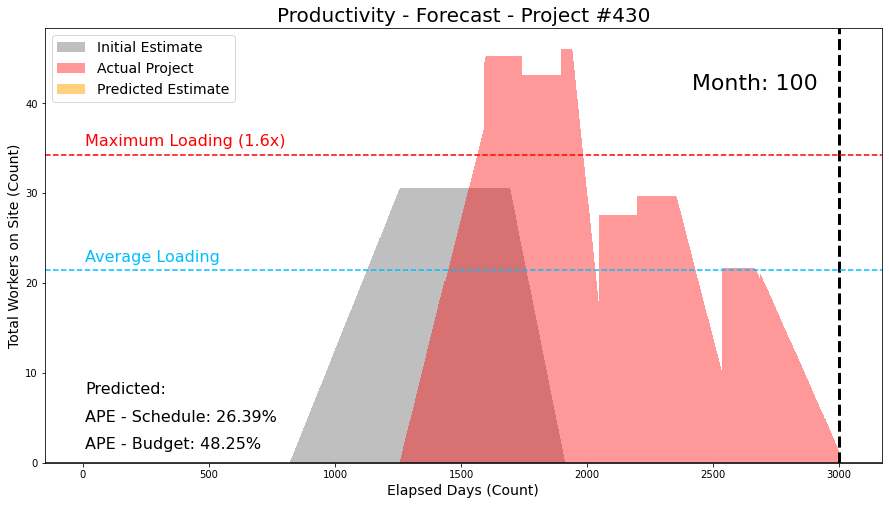

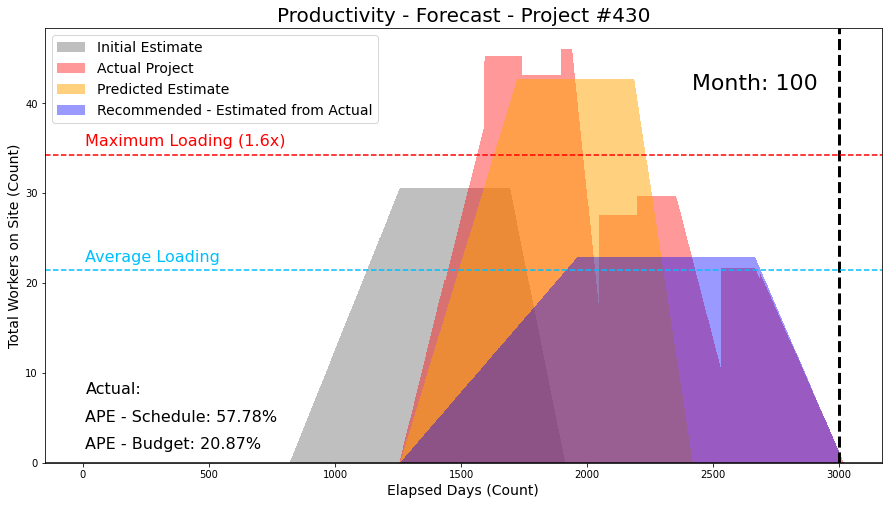

In [0]:
##############################################

# TIME STEP ANIMATIONS FOR PRODUCTIVITY

##############################################

#set flags for plotting
show_animation = False

#Combinations of curves to plot (4 different animation passes)
#[show_initial, show_predicted, show_project_sim, show_expected]
# aka [show_grey, show_orange, show_red, show_blue]
plotting_combinations = [[True,False,False,False],[True,True,False,False],[True,True,True,False],[True,True,True,True]] 

#timestep to show (if static plot)
current_month_t = 100

# display images?
display_plots = True

# save images?
save_plots = False

# save directory:
image_filepath = "/content/drive/Shared drives/CSCI E-109B - Adv Data Sci - Final Project (E)/exported_plots/"

legend_location = "upper left" #"upper right"

#run each animation
for combination in range(0,len(plotting_combinations)):
  show_initial,show_predicted,show_project_sim,show_expected = plotting_combinations[combination]

  ##############################################

  if not show_animation:
    day_t = current_month_t * days_per_month

  ##############################################

  maximum_sim_length = max( len(initial_ape_load),len(expected_ape_load), len(predicted_ape_load) ) #whats the latest forecasted completion time?
  maximum_peak_height = max ( max(initial_ape_load), max(expected_ape_load), max(predicted_ape_load), max(project_simulation_df.today_labor_hours_total) )

  if show_animation:
    days = range(1, maximum_sim_length, 1)
  if not show_animation:
    days = range(day_t, day_t+1, 1)

  ##############################################

  for day in days: #for each time t of project
    # print(day)
    if show_animation:
      month_step = days_per_month * 3
    if not show_animation:
      month_step = days_per_month
    if (day % month_step) == 0: #if its the end of month
      current_month_t = int(day/(days_per_month))
      #print( "Yes, month %s, day %s" % (int(day/30), day) )

      #take subset of values
      initial_ape_load_subset = initial_ape_load[:day] #show up to time_t
      project_sim_subset = project_simulation_df.today_labor_hours_total
      project_sim_subset = project_sim_subset[:day] #show up to time_t

      if show_predicted and not show_project_sim:
        predicted_ape_load_subset = predicted_ape_load[:day] #show predicted AFTER time_t

      if show_predicted and show_project_sim:
        predicted_ape_load_subset = []
        for i in range(1,day+1):
          predicted_ape_load_subset.append(0)
        predicted_ape_load_subset = predicted_ape_load_subset + predicted_ape_load[day:] #show predicted AFTER time_t

      expected_ape_load_subset = expected_ape_load[:day] #show up to time_t

      ##############################################

      plt.figure(figsize=(15,8))
      if show_initial and not show_predicted:
        plt.bar(range(1,len(initial_ape_load_subset)+1,1), initial_ape_load_subset, color="grey", width=1, alpha=0.5, label="Initial Estimate")
      if show_initial and show_predicted:
        plt.bar(range(1,len(initial_ape_load)+1,1), initial_ape_load, color="grey", width=1, alpha=0.5, label="Initial Estimate")
      if show_project_sim and not show_expected:
        plt.bar(range(1,len(project_sim_subset)+1,1), (project_sim_subset), width=1, alpha=0.4, color="red", label="Actual Project")
      if show_project_sim and show_expected:
        plt.bar(range(0,len(project_simulation_df),1), (project_simulation_df.today_labor_hours_total), width=1, alpha=0.4, color="red", label="Actual Project")      
      if show_predicted and not show_expected:
        plt.bar(range(1,len(predicted_ape_load_subset)+1,1), predicted_ape_load_subset, color="orange", width=1, alpha=0.5, label="Predicted Estimate")
      if show_expected:
        plt.bar(range(1,len(predicted_ape_load)+1,1), predicted_ape_load, color="orange", width=1, alpha=0.5, label="Predicted Estimate")     
        plt.bar(range(1,len(expected_ape_load_subset)+1,1), expected_ape_load_subset, color="blue", width=1, alpha=0.4, label="Recommended - Estimated from Actual")
        
      plt.title("Productivity - Forecast - Project #%s" % project_number, fontsize=20)
      plt.xlabel("Elapsed Days (Count)", fontsize=14)
      plt.ylabel("Total Workers on Site (Count)", fontsize=14)

      x_padding = maximum_sim_length*0.05
      y_padding = maximum_peak_height*0.05
      plt.xlim(-x_padding, (maximum_sim_length + x_padding))
      plt.ylim(0, (maximum_peak_height + y_padding))

      t_x_pos = maximum_sim_length*0.80
      y_x_pos = maximum_peak_height*0.90

      plt.text(t_x_pos, y_x_pos, "Month: %s" % (current_month_t), fontsize=22)

      plt.axhline(0, color="black") #Zero Line
      plt.axvline(day, linestyle="--", linewidth=3, color="black") #Current Timestep

      if show_project_sim:
          plt.axhline(initial_recommended_max, linestyle="--", color="red") #Overloading Line
          plt.axhline(initial_ape_load_mean, linestyle="--", color="deepskyblue") #Average Labor Line
          plt.text(10, initial_recommended_max+1, "Maximum Loading (1.6x)", color="red", fontsize=16)
          plt.text(10, initial_ape_load_mean+1, "Average Loading", color="deepskyblue", fontsize=16)


      if show_predicted and not show_expected:
        x_pos = 10
        y_pos_up = max(initial_ape_load) - (max(initial_ape_load)*.75)
        plt.text(x_pos, y_pos_up, "Predicted:", fontsize=16)
        y_pos_middle = y_pos_up - (max(initial_ape_load) * 0.10)      
        plt.text(x_pos, y_pos_middle, "APE - Schedule: %.2f%%" % (predicted_ape_sched*100), fontsize=16)
        y_pos_low = y_pos_middle - (max(initial_ape_load) * 0.10)
        plt.text(x_pos, y_pos_low, "APE - Budget: %.2f%%" % (predicted_ape_budget*100), fontsize=16)

      if show_expected:
        x_pos = 10
        y_pos_up = max(initial_ape_load) - (max(initial_ape_load)*.75)
        plt.text(x_pos, y_pos_up, "Actual:", fontsize=16)
        y_pos_middle = y_pos_up - (max(initial_ape_load) * 0.10)      
        plt.text(x_pos, y_pos_middle, "APE - Schedule: %.2f%%" % (actual_ape_sched*100), fontsize=16)
        y_pos_low = y_pos_middle - (max(initial_ape_load) * 0.10)
        plt.text(x_pos, y_pos_low, "APE - Budget: %.2f%%" % (actual_ape_budget*100), fontsize=16)

      plt.legend(fontsize=14, loc=legend_location)
      
      if display_plots:
        plt.show()

      if save_plots:
        image_name = ""

        if show_initial:
          image_name = image_name + "1"
        else:
          image_name = image_name + "0"

        if show_project_sim:
          image_name = image_name + "1"
        else:
          image_name = image_name + "0"

        if show_predicted:
          image_name = image_name + "1"
        else:
          image_name = image_name + "0"

        if show_expected:
          image_name = image_name + "1"
        else:
          image_name = image_name + "0"

        image_name = image_name + "_project_" + str(project_number) + "_month_" + str(current_month_t)

        plt.savefig(image_filepath + image_name)

      plt.close()

- Plots Labor Loading Breakdown for each Loading Curve
  - Quantity of worker type per each day 

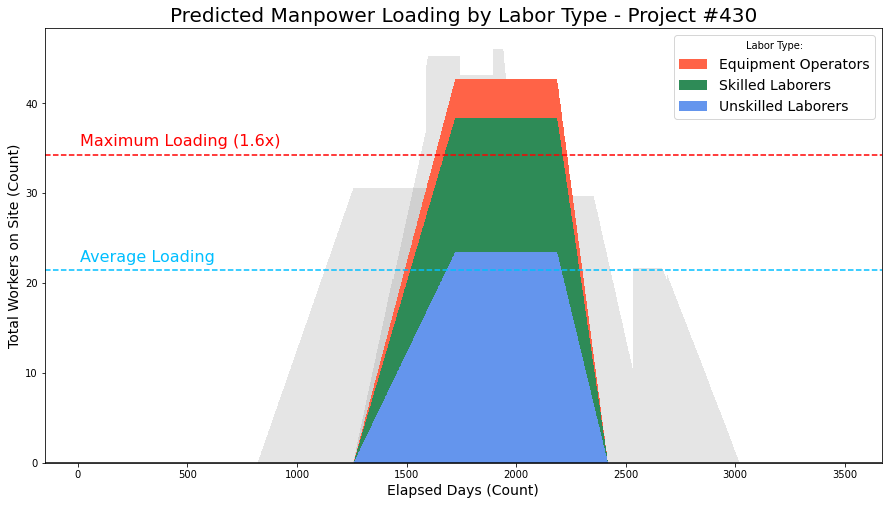

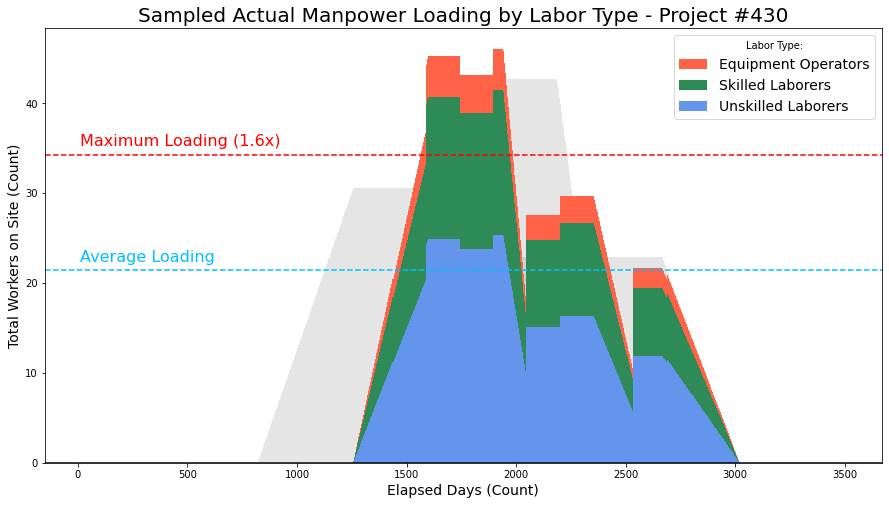

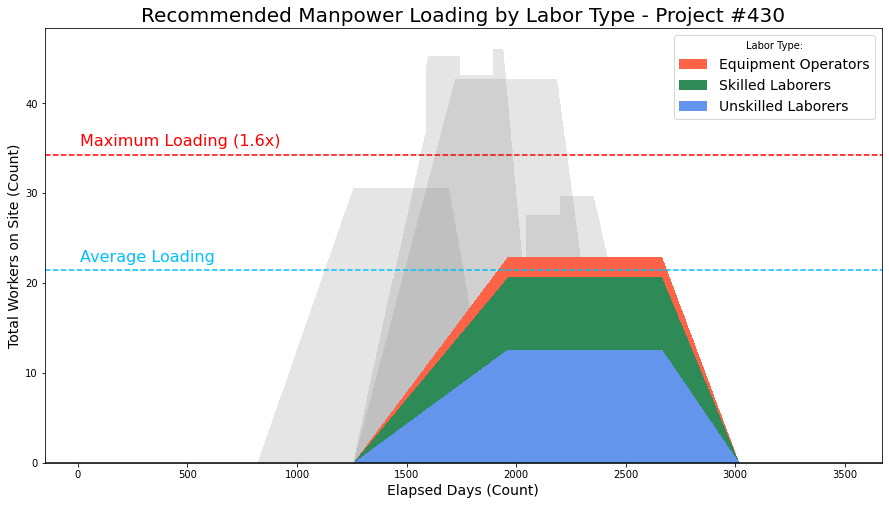

In [0]:
##############################################

# VISUALIZATIONS FOR TYPES OF WORKERS ON PROJECT

##############################################

predicted_unskilled_laborers = [x * project_weights[1][2] for x in predicted_ape_load]

predicted_skilled_laborers = [x * project_weights[1][1] for x in predicted_ape_load]
for i in range(0,len(predicted_unskilled_laborers)):
  predicted_skilled_laborers[i] = predicted_skilled_laborers[i] + predicted_unskilled_laborers[i]
  
predicted_equipment_operators_loading = predicted_ape_load

expected_unskilled_laborers = [x * project_weights[1][2] for x in expected_ape_load]

expected_skilled_laborers = [x * project_weights[1][1] for x in expected_ape_load]
for i in range(0,len(expected_unskilled_laborers)):
  expected_skilled_laborers[i] = expected_skilled_laborers[i] + expected_unskilled_laborers[i]
  
expected_equipment_operators_loading = expected_ape_load

actual_labor_curve = project_simulation_df.today_labor_hours_total

actual_unskilled_laborers = [x * project_weights[1][2] for x in actual_labor_curve]

actual_skilled_laborers = [x * project_weights[1][1] for x in actual_labor_curve]
for i in range(0,len(actual_unskilled_laborers)):
  actual_skilled_laborers[i] = actual_skilled_laborers[i] + actual_unskilled_laborers[i]
  
actual_equipment_operators_loading = actual_labor_curve

##############################################

#PREDICTED LABOR BREAKDOWN

plt.figure(figsize=(15,8))
plt.bar(range(1,len(initial_ape_load)+1,1), initial_ape_load, color="grey", width=1, alpha=0.2)
plt.bar(range(1,len(project_simulation_df)+1,1), (project_simulation_df.today_labor_hours_total), width=1, alpha=0.2, color="grey")
plt.bar(range(1,len(predicted_equipment_operators_loading)+1,1), predicted_equipment_operators_loading, color="tomato", width=1, alpha=1.0, label="Equipment Operators")
plt.bar(range(1,len(predicted_skilled_laborers)+1,1), predicted_skilled_laborers, color="seagreen", width=1, alpha=1.0, label="Skilled Laborers")
plt.bar(range(1,len(predicted_unskilled_laborers)+1,1), predicted_unskilled_laborers, color="cornflowerblue", width=1, alpha=1.0, label="Unskilled Laborers")

plt.title("Predicted Manpower Loading by Labor Type - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)
plt.ylabel("Total Workers on Site (Count)", fontsize=14)

x_padding = maximum_sim_length*0.05
y_padding = maximum_peak_height*0.05
plt.xlim(-x_padding, (maximum_sim_length + x_padding+500))
plt.ylim(0, (maximum_peak_height + y_padding))

plt.axhline(0, color="black") #Zero Line
plt.axhline(initial_recommended_max, linestyle="--", color="red") #Overloading Line
plt.axhline(initial_ape_load_mean, linestyle="--", color="deepskyblue") #Average Labor Line
plt.text(10, initial_recommended_max+1, "Maximum Loading (1.6x)", color="red", fontsize=16)
plt.text(10, initial_ape_load_mean+1, "Average Loading", color="deepskyblue", fontsize=16)

plt.legend(title="Labor Type:", fontsize=14, loc='upper right')
plt.show()
plt.close()

##############################################

#SAMPLED ACTUAL LABOR BREAKDOWN

plt.figure(figsize=(15,8))
plt.bar(range(1,len(initial_ape_load)+1,1), initial_ape_load, color="grey", width=1, alpha=0.2)
plt.bar(range(1,len(expected_ape_load)+1,1), (expected_ape_load), width=1, alpha=0.2, color="grey")
plt.bar(range(1,len(predicted_ape_load)+1,1), (predicted_ape_load), width=1, alpha=0.2, color="grey")
plt.bar(range(1,len(actual_equipment_operators_loading)+1,1), actual_equipment_operators_loading, color="tomato", width=1, alpha=1.0, label="Equipment Operators")
plt.bar(range(1,len(actual_skilled_laborers)+1,1), actual_skilled_laborers, color="seagreen", width=1, alpha=1.0, label="Skilled Laborers")
plt.bar(range(1,len(actual_unskilled_laborers)+1,1), actual_unskilled_laborers, color="cornflowerblue", width=1, alpha=1.0, label="Unskilled Laborers")

plt.title("Sampled Actual Manpower Loading by Labor Type - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)
plt.ylabel("Total Workers on Site (Count)", fontsize=14)

x_padding = maximum_sim_length*0.05
y_padding = maximum_peak_height*0.05
plt.xlim(-x_padding, (maximum_sim_length + x_padding+500))
plt.ylim(0, (maximum_peak_height + y_padding))

plt.axhline(0, color="black") #Zero Line
plt.axhline(initial_recommended_max, linestyle="--", color="red") #Overloading Line
plt.axhline(initial_ape_load_mean, linestyle="--", color="deepskyblue") #Average Labor Line
plt.text(10, initial_recommended_max+1, "Maximum Loading (1.6x)", color="red", fontsize=16)
plt.text(10, initial_ape_load_mean+1, "Average Loading", color="deepskyblue", fontsize=16)

plt.legend(title="Labor Type:", fontsize=14, loc='upper right')
plt.show()
plt.close()

##############################################

#RECOMMENDED LABOR BREAKDOWN

plt.figure(figsize=(15,8))
plt.bar(range(1,len(initial_ape_load)+1,1), initial_ape_load, color="grey", width=1, alpha=0.2)
plt.bar(range(1,len(project_simulation_df)+1,1), (project_simulation_df.today_labor_hours_total), width=1, alpha=0.2, color="grey")
plt.bar(range(1,len(predicted_ape_load)+1,1), (predicted_ape_load), width=1, alpha=0.2, color="grey")
plt.bar(range(1,len(expected_equipment_operators_loading)+1,1), expected_equipment_operators_loading, color="tomato", width=1, alpha=1.0, label="Equipment Operators")
plt.bar(range(1,len(expected_skilled_laborers)+1,1), expected_skilled_laborers, color="seagreen", width=1, alpha=1.0, label="Skilled Laborers")
plt.bar(range(1,len(expected_unskilled_laborers)+1,1), expected_unskilled_laborers, color="cornflowerblue", width=1, alpha=1.0, label="Unskilled Laborers")

plt.title("Recommended Manpower Loading by Labor Type - Project #%s" % project_number, fontsize=20)
plt.xlabel("Elapsed Days (Count)", fontsize=14)
plt.ylabel("Total Workers on Site (Count)", fontsize=14)

x_padding = maximum_sim_length*0.05
y_padding = maximum_peak_height*0.05
plt.xlim(-x_padding, (maximum_sim_length + x_padding+500))
plt.ylim(0, (maximum_peak_height + y_padding))

plt.axhline(0, color="black") #Zero Line
plt.axhline(initial_recommended_max, linestyle="--", color="red") #Overloading Line
plt.axhline(initial_ape_load_mean, linestyle="--", color="deepskyblue") #Average Labor Line
plt.text(10, initial_recommended_max+1, "Maximum Loading (1.6x)", color="red", fontsize=16)
plt.text(10, initial_ape_load_mean+1, "Average Loading", color="deepskyblue", fontsize=16)

plt.legend(title="Labor Type:", fontsize=14, loc='upper right')
plt.show()
plt.close()

# -----------------------------------------------------------------------------------------------------------------

#5 - Conclusions

- **BiGRU Models:**
  - We can successfully predict whether a project will be over budget or over schedule based on the text of the project description.
  - Our models are "optimistic" in predictions: the models tend to have a higher false negative rate; predicting that the project will be on budget/schedule when in reality it is over budget/schedule.
    - Since the data is overwhelmingly "unsuccessful" projects (that are overschedule or overbudget), this indicates our *data balancing was effective*.
    - The inherent bias in the dataset has shifted toward predicting projects as successful. 


- **Budget APE baseline linear regression model:**

  - The average project is approximately 27% over budget
  - None of the binary flags we added that describe scope using keywords were statistically significant.  
  - Projects that had more site storage (Site_storage_1) had a lower budget error and this is logical since projects with more site storage have less logistical complexity and consequently less opportunity for budget overruns.
  - Projects that involve the NYC Mayor's office are more likely to have budget overruns.  
  - If the Department of Design and Construction is managing the project, it's more likely to be overbudget.
  - DOT projects are likely to be underbudget unless they are a street or roadway project; street and roadway projects are highly likely to be overbudget.
  - Prisons and police stations tend to be underbudget.
  - Increase in total schedule change is likely to cause a budget overrun, but the magnitude of the budget overrun is decreased with a larger latest schedule change (if your largest schedule change is at the last minute, it is less likely to impact the budget.  This is logical because you simply have less time to spend money).


- **Schedule APE baseline linear regression model:**

  - The average NYC project will be 25% over schedule.
  - Projects which are still in design (have not started construction) are more likely to be over schedule.  
  - NYC School construction is more likely to finish on time.  This includes school projects paid for by the NYC Department of Education and managed by the NYC School Construction Authority.
  - Environmental protection and climate change projects (includes DEP and ORR projects) are more likely to come in on schedule.  
  - Santiation projects are more likely to be completed on schedule.
  - Safety projects are slightly more likely to be completed on schedule. 

-  **Visualizing Project Success:**
  - Iteratively processing the data for each timestep, we can *simulate the completion process* of a project, indicating *what amount of scope is completed at what time*.
      - The measure simulated is "manpower", the number of workers on a site at any time. This is the closest estimation of the amount of scope being completed.
  - We use a Bayesian approach in this project, first taking prior information about a project distribution, and then transforming that using liklihood project data, to produce a project specific posterior distribution.   
    - Our Bayesian prior distributions are for *manpower loading,* and are based on researched trade/industry knowledge.
      - As noted in our presentation, they are typically left-skewed normal distributions (or beta distributions). Often industry guides estimate them using a "loading trapezoid".
      - Since the data is being largely estimated, We believed the nuanced differences with chosing a skewed normal would be irrelevant, and thus the *trapezoid approximation was the prior selected*.
    - These "loading trapezoids" indicate what amount of "progress" (cumulative quantity of labor) should be expected at each time step of project. They also indicate a recommended "maximum" loading for the most productive labor.
          - Above the recommended loading, is an area of "*overloading*" - because *projects are spatially restricted* (they have a physical spatial dimension like floor area), adding more workers does not linearly equal more productivity.
          - "Overloaded" projects spend money too quickly, since labor cannot efficiently work. 
    - Another set of prior distributions are how cost relates to labor: Using different linear equations for cost and labor type for each project category, we can estimte the number of labor hours per project.   
  - Visualizing these loading diagrams *(initial, predicted, sampled actual and recommended)* allows us to know where we are, where we're going, and where we should be as we progress through a project.
    - This allows a project manager to prevent overloading a project. 
    - This allows the project manager to make better strategic decisions at any timestep about what to anticipate (reduce labor, increase labor), and thus make a more successful project.


  

# -----------------------------------------------------------------------------------------------------------------

#6 - Next Steps

- **Further Data Collection:**
  - One of the significant project hurdles was estimating the project scope. Any project has a clearly defined set of tasks, and a critical path to completion to schedule those tasks. Since this information was not available in the dataset, we use descriptive flags found in the project text. However, to do any further analysis, wide scale data collection will be required into each project, such as:
    - Knowing the actual Gantt chart of project tasks, showing times and critical path.
    - Knowing the project specific areas, in square feet/meters, and site size.
    - Knowing the site logistics.
    - Knowing a Schedule of Values/Budget Breakdown (value of each project task)
  - This will be a tremendous undertaking since Construction data is largely heterogeneous, and must be transformed to be Neural Network or Model ready. 

- **Monte-Carlo Simulation:**
  - If slightly more project data is known, such as a range of values for each project cost or labor type (triangular distribution), then Monte-Carlo simulation could be done.
  - This would allow Empirical Cumulative Distribution Functions (probability "S" curves) to estimate the liklihood of each schedule and budget outcome, and let a project manager better understand the probability of success given a decision.

- **Reinforcement Learning:**
  - Because our loading diagrams have low/medium/high states, and loading has clearly defined project phases, it seems natural to apply a game-theoretic Reinforcement Learning approach  to this obvious optimization problem.
  - The barrier is *not knowing what actions one can take* in each state.
    - We can assume three actions currently: add labor, do nothing, remove labor. But the outcome of such a RL Markov Decision Process is *obvious* - it does not require computational power to solve.
  - If we understand in detail what all the tasks are, we can run which tasks are to be completed, and thus which actions are available, we can determine action-values (for each action in each state). This would allow the project to become a game board where all information about the environment is known, and where an agent could explore and determine the ideal decision to make at each time step for a successful project. 

- **Research into Phased Projects:**
  - Our Priors assume the project is being completed in one pass, and not in smaller bursts (phases) - this is not always the case, especially with larger projects. The left-skewed normal loading curve represents a typical project with a ramp up, "peak", and ramp down. Further modeling would be required to properly represent phased projects.
    - This may be serial application of our approach - typically phased projects are often considered separate projects. This would simplify the modeling.  

# -----------------------------------------------------------------------------------------------------------------

#7 - References


- Cullen, Scott W., 2016, Earned Value Analysis, Whole Building Design Guide, National Institute of Building Sciences, Retrieved from http://www.wbdg.org/resources/earned-valueanalysis?r=utilize_management.

- Hanna, A. S. "NECA Curves: Foundation Study, Seven projects to provide benchmarks and explore adverse working conditions on construction projects", March 2015, Retrieved from https://apps.necanet.org/about/press/index.cfm?fa=show&articleID=210.

- Hendrickson, C. and Au, T. "Advanced Monte Carlo techniques for Construction Scheduling", July 2008, Department of Civil and Environmental Engineering, Carnegie Mellon University, Retrieved from https://www.cmu.edu/cee/projects/PMbook/11_Advanced_Scheduling_Techniques.html. 

- Hendrickson, C. and Au, T. "Project Management for Construction: Construction Planning", Department of Civil and Environmental Engineering, Carnegie Mellon University,July 2008. Retrieved from https://www.cmu.edu/cee/projects/PMbook/09_Construction_Planning.html.

- Orczyk, Joseph, "Construction Project Cost Control" (2018). School of Construction Management Technology Open Educational Resources, Purdue University, Retrieved from https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1000&context=bcmoer.

- Wideman, R. M. "Project Management Examined." Lecture material for the University of Victoria, British Columbia, Dec 2000.

- Wideman, R. M. Canadian Journal of Civil Engineering, Vol. 21, 1994 (rev 2001) pp 939-953, "A Pragmatic Approach to Using Resource Loading, Production and Learning Curves on Construction Projects".

- Wideman, R. M.(2001, April 15). "Applying Resource Loading, Production and Learning Curves to Construction: A Pragmatic Approach". Retrieved from http://www.maxwideman.com/papers/managing/manpower.html, http://www.maxwideman.com/papers/resource/learned.html & http://www.maxwideman.com/papers/resource/conclusions.html.

# -----------------------------------------------------------------------------------------------------------------

Milestone 3 | Project E - Group 48 - Michael Lee, Micah Nickerson, Daniel Olal | CSCI-109-B Advanced Topics in Data Science, Spring 2020

# -----------------------------------------------------------------------------------------------------------------